# Intro
Name:  

    ORACLES_Build_DARE

Purpose:  

    Build the aerosol radiative effect input files from the SSFR reflectances, 4STAR AOD, and 4STAR skyscan results
  
Input:

    none at command line
  
Output:

    figures and save files...
  
Keywords:

    none
  
Dependencies:

    - Sp_parameters.py : for Sp class definition, and for defining the functions used to build parameters
    - matplotlib
    - numpy
    - scipy : for saving and reading
    - plotting_utils (user defined plotting routines)
    - hdf5storage
  
Needed Files:

  - file.rc : for consistent creation of look of matplotlib figures
  - 4STAR_cloud retrieval .mat files
  
Modification History:
 
     Written: by Samuel LeBlanc, Santa Cruz, CA, 2019-12-02
     
     Modified: by Samuel LeBlanc, Santa Cruz, CA, 2020-11-18
             - updated for R4 ORACLES 2016 and mie 2020-11-12
     Modified: by Samuel LeBlanc, Santa Cruz, C, 2021-02-04
             - updated with delta SSA +/-0.03 for v5

# Import of modules

In [1]:
import numpy as np
import hdf5storage as hs
import os
import write_utils as wu
import scipy.io as sio
from path_utils import getpath
import matplotlib.pyplot as plt
import load_utils as lu
from write_utils import nearest_neighbor, iterate_dict_unicode

In [2]:
%matplotlib notebook

In [3]:
from tqdm.notebook import tqdm 
from datetime import datetime, timedelta

In [4]:
from multiprocessing import Pool, cpu_count
from copy import deepcopy
import signal
import warnings
warnings.simplefilter('ignore')

In [5]:
from scipy.interpolate import interp1d

In [6]:
import Run_libradtran as Rl

In [7]:
name = 'ORACLES'

In [8]:
vv = 'v5'
vr = 'R4'

In [9]:
fp = getpath(name)
fp_rtm = getpath('rtm')
fp_uvspec = getpath('uvspecb')+'uvspec'
matfile = fp+'{}_all_cld_ict.mat'.format(vr)
fp_uvspec_dat = getpath('uvspec_dat') 
fp_rtmdat = fp_rtm+'dat/'

Return path named:  ORACLES /data/sam/ORACLES/
Return path named:  rtm /scratch/rtm/
Return path named:  uvspecb /home/sam/libradtran/libRadtran-2.0.2b/bin/
Return path named:  uvspec_dat /home/sam/libradtran/libRadtran-2.0.2/data/


# Load the files

## Load the 4STAR AOD

In [10]:
ar = hs.loadmat(fp+'/aod_ict/{v}/all_aod_ict_{v}_2016.mat'.format(v=vr,vi='v9'))

In [11]:
ar.keys()

[u'AOD1040',
 u'AOD0532',
 u'AOD0530',
 u'UNCAOD0550',
 u'UNCAOD0700',
 u'AOD0355',
 u'AOD1627',
 u'AOD0520',
 u'UNCAOD0620',
 u'AOD0606',
 u'AOD1064',
 u'Latitude',
 u'UNCAOD0452',
 u'fl_alt_6',
 u'AOD0620',
 u'AOD0700',
 u'AOD0550',
 u'AOD0660',
 u'UNCAOD1627',
 u'AOD0452',
 u'fl_routine',
 u'AOD0470',
 u'fl1',
 u'UNCAOD1236',
 u'fl3',
 u'fl2',
 u'UNCAOD1064',
 u'UNCAOD0501',
 u'AOD_angstrom_470_865',
 u'AOD_polycoef_a0',
 u'AOD_polycoef_a2',
 u'UNCAOD0606',
 u'UNCAOD0355',
 u'qual_flag',
 u'UNCAOD0675',
 u'AOD1559',
 u'UNCAOD1650',
 u'UNCAOD1559',
 u'UNCAOD1250',
 u'AOD0501',
 u'Longitude',
 u'AOD_polycoef_a1',
 u'UNCAOD0660',
 u'GPS_Alt',
 u'AOD1250',
 u'flac',
 u'UNCAOD0380',
 u'fl',
 u'AOD0675',
 u'fl_QA',
 u'AOD1236',
 u'AOD1650',
 u'UNCAOD0470',
 u'AOD0380',
 u'UNCAOD0865',
 u'Start_UTC',
 u'flr',
 u'UNCAOD0781',
 u'days',
 u'UNCAOD0520',
 u'fl_alt_22',
 u'AOD0781',
 u'fl_alt_18',
 u'flag_acaod',
 u'fl_alt',
 u'AOD0865',
 u'amass_aer',
 u'flacr',
 u'UNCAOD1020',
 u'UNCAOD0532',

In [12]:
ar['AOD0501'].shape

(483692,)

In [13]:
sza = np.arccos(1.0/ar['amass_aer'])*180.0/np.pi

In [14]:
days = ['20160824','20160825','20160827','20160830','20160831','20160902','20160904','20160906','20160908',
       '20160910','20160912','20160914','20160918','20160920','20160924','20160925','20160927','20160930']

In [15]:
len(days)

18

In [16]:
ar['days']

array([ 0.,  0.,  0., ..., 17., 17., 17.])

## Load the retrieved Cloud properties

In [17]:
cl = hs.loadmat(fp+'data_other/ssfr_2016_retrieved_COD_{}.mat'.format('v4'))
print 'loading: '+fp+'data_other/ssfr_2016_retrieved_COD_{}.mat'.format('v4')

loading: /data/sam/ORACLES/data_other/ssfr_2016_retrieved_COD_v4.mat


In [18]:
cl.keys()

[u'tau',
 u'aod',
 u'utc',
 u'Rvis',
 u'ki',
 u'sza',
 u'lon',
 u'days',
 u'a1',
 u'a0',
 u'a2',
 u'Rnir',
 u'lat',
 u'Rvis_mod',
 u'Rnir_mod',
 u'ref']

In [19]:
cl['tau'].shape

(380923,)

In [20]:
dds = ['20160830','20160831','20160902','20160904','20160906','20160908',
       '20160910','20160912','20160914','20160918','20160920','20160924','20160925','20160927']

In [21]:
len(dds)

14

In [22]:
cl['days']

array([ 0.,  0.,  0., ..., 13., 13., 13.])

In [23]:
dd = np.unique(cl['days'])

In [24]:
cod,ref = [],[]
for d in dd:
    print d
    fld = cl['days']==d
    fad = ar['days']==d+3.0
    #nearest neighbor, but not more than a minute away
    cod_tmp = nearest_neighbor(cl['utc'][fld],cl['tau'][fld],ar['Start_UTC'][fad],dist=1.0/60.0) 
    ref_tmp = nearest_neighbor(cl['utc'][fld],cl['ref'][fld],ar['Start_UTC'][fad],dist=1.0/60.0)
    cod = np.append(cod,cod_tmp)
    ref = np.append(ref,ref_tmp)

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0


In [25]:
cod.shape

(379755,)

In [26]:
len(dds)

14

In [27]:
len(np.unique(ar['days']))

18

## Load the skyscan retrievals

In [28]:
try:
    ae,ae_dict = lu.load_netcdf(fp+'aeroinv_2016/netcdf4/4STAR-aeroinv_P3_2016_R0.nc',everything=True)
except:
    import h5py as h5
    f5 = h5.File(fp+'aeroinv_2016/netcdf4/4STAR-aeroinv_P3_2016_R0.nc','r')
    ae5 = {}
    ae5_dict = {}
    for ka,kd in f5.iteritems():
        ae5[ka] = kd.value
        ae5_dict[ka] = {}
        for kdict in kd.attrs.iteritems():
            if type(kdict[1])!=type(np.array([])):
                ae5_dict[ka][kdict[0]] = kdict[1]
    ae = ae5
    ae_dict = ae5_dict

Reading file: /data/sam/ORACLES/aeroinv_2016/netcdf4/4STAR-aeroinv_P3_2016_R0.nc


In [29]:
ke = ae.keys()
ke.sort()
ke

[u'AAOD',
 u'AGOD',
 u'AOD_fit_coarse',
 u'AOD_fit_fine',
 u'AOD_fit_total',
 u'AOD_meas',
 u'GPS_Altitude',
 u'GPS_Altitude_std',
 u'Heading',
 u'Heading_std',
 u'Lat',
 u'Lon',
 u'PF_angle',
 u'PF_coarse',
 u'PF_fine',
 u'PF_total',
 u'PWV',
 u'P_static',
 u'Pitch',
 u'Pitch_std',
 u'QA_level',
 u'RH',
 u'Roll',
 u'Roll_std',
 u'SA',
 u'SAZ',
 u'SEL',
 u'SSA',
 u'SZA',
 u'TOD_fit',
 u'TOD_meas',
 u'TOD_meas_minus_fit',
 u'T_static',
 u'base_time',
 u'g_coarse',
 u'g_fine',
 u'g_total',
 u'm_ray',
 u'n_imag',
 u'n_real',
 u'normalized_sky_radiance',
 u'normalized_sky_radiance_fit',
 u'psd',
 u'radius',
 u'sca_angle',
 u'scan_tag',
 u'scan_type',
 u'sfc_alb',
 u'sky_radiance_fit_error',
 u'sphericity',
 u'sphericity_err',
 u'time',
 u'time_offset',
 u'wavelength']

In [29]:
ae['AOD_meas'][0]

array([0.2365, 0.1788, 0.1115, 0.0665, 0.0549])

In [30]:
ae_dict['AAOD']

{u'Comment': 'Based on AERONET inversion criteria in https://aeronet.gsfc.nasa.gov/new_web/Documents/AERONETcriteria_final1.pdf',
 u'Comment2': 'A consequence of the symmetry requirement for level 2 is that PPL scans can assess at no higher than 1.5',
 u'_Netcdf4Dimid': 0,
 u'lev1': 'Has at least one point at all wavelengths in each of 4 scattering angle ranges',
 u'lev1p5': 'Has 10+ values at all wavelengths with scattering angle >80 deg and at least one point in each of 4 scattering angle ranges',
 u'lev2': 'Has 21+ values at all wavelengths with scattering angle >80 deg and multiple points in each of 4 scattering angle ranges, and <20% asymmetry between CW and CCW legs',
 u'long_name': 'absorption AOD',
 u'source': 'retrieval',
 u'units': 'unitless',
 u'values': '1.0 1.5 2.0'}

In [31]:
ae_dict['SSA']

{u'Comment': 'Based on AERONET inversion criteria in https://aeronet.gsfc.nasa.gov/new_web/Documents/AERONETcriteria_final1.pdf',
 u'Comment2': 'A consequence of the symmetry requirement for level 2 is that PPL scans can assess at no higher than 1.5',
 u'_Netcdf4Dimid': 0,
 u'lev1': 'Has at least one point at all wavelengths in each of 4 scattering angle ranges',
 u'lev1p5': 'Has 10+ values at all wavelengths with scattering angle >80 deg and at least one point in each of 4 scattering angle ranges',
 u'lev2': 'Has 21+ values at all wavelengths with scattering angle >80 deg and multiple points in each of 4 scattering angle ranges, and <20% asymmetry between CW and CCW legs',
 u'long_name': 'single scattering albedo',
 u'source': 'retrieval',
 u'units': 'unitless',
 u'values': '1.0 1.5 2.0'}

In [32]:
ae['SSA'].shape

(84, 5)

In [33]:
ae_dict['time']

{u'CLASS': 'DIMENSION_SCALE',
 u'NAME': 'time',
 u'_Netcdf4Dimid': 0,
 u'long_name': 'Time offset from midnight',
 u'units': 'seconds since 2016-08-31 00:00:00 0:00'}

In [34]:
ae['time']/3600.0

array([  9.36436349,   9.38314424,  11.44100489,  13.53473135,
        13.55286422,  13.63317105,  13.65609344,  14.15397498,
        14.17291726,  55.12454682,  56.45493072,  56.47428852,
        56.50556153,  56.52408765,  56.62796449,  56.64651974,
        57.3145811 ,  57.57097029,  57.58955459,  58.57214188,
        58.99556736,  60.49512862,  60.51375567,  60.53747322,
        62.83647775, 153.56740963, 153.58586041, 154.09168935,
       154.11113343, 154.98052584, 155.82233424, 155.84067681,
       156.42516806, 156.44378445, 157.14872684, 157.16740038,
       203.2280269 , 251.08488591, 252.31515166, 300.24803314,
       301.14747711, 301.1660435 , 301.18294843, 301.7608256 ,
       301.77941441, 302.12064148, 302.14029531, 345.31344008,
       345.33189656, 346.52380833, 346.63178176, 346.6632354 ,
       349.91946379, 441.84949381, 489.40488159, 489.42472078,
       489.45796597, 489.48503416, 489.52466494, 489.55642007,
       489.58136179, 491.02055947, 491.14471216, 492.66

In [35]:
days = ['20160824','20160825','20160827','20160830','20160831','20160902','20160904','20160906','20160908',
       '20160910','20160912','20160914','20160918','20160920','20160924','20160925','20160927','20160930']

In [36]:
ar['doy'] = np.array([datetime.strptime(days[int(d)],'%Y%m%d').timetuple().tm_yday for d in ar['days']])

In [37]:
datetime.strptime(days[4],'%Y%m%d').timetuple().tm_yday

244

In [38]:
ar['time_ae'] = ar['Start_UTC']+(24.0*(ar['doy']-244))

In [39]:
ar['time_ae']

array([-156.14305556, -156.14277778, -156.1425    , ...,  737.93      ,
        737.93027778,  737.93055556])

## Load the MODIS cloud retrievals

In [40]:
import pytz

In [41]:
fp

u'/data/sam/ORACLES/'

In [42]:
fmod = os.listdir(fp+'data_other/MODIS/MOD06_L2/2016/268/')
fgeo = os.listdir(fp+'data_other/MODIS/MOD03/2016/268/')
fmod.sort()
fgeo.sort()

In [45]:
vals = (('QA',123),('CF',38),('ref',66),('COD',72),('mask',110),('t',0))

In [46]:
geo,geo_dict = lu.load_hdf(fp+'data_other/MODIS/MOD03/2016/268/'+fgeo[0],values=(('lat',12),('lon',13)),verbose=False)

In [47]:
def bits_stripping(bit_start,bit_count,value):
	bitmask=pow(2,bit_start+bit_count)-1
	return np.right_shift(np.bitwise_and(value,bitmask),bit_start)

In [48]:
def mod_qa(aq_val):
    qa_cod_useful = bits_stripping(0,1,aq_val[4])
    qa_cod_conf = bits_stripping(1,2,aq_val[4])
    qa_ref_useful = bits_stripping(3,1,aq_val[4])
    qa_ref_conf = bits_stripping(4,2,aq_val[4])
    return (qa_cod_useful>0) & (qa_cod_conf>1) & (qa_ref_useful>0) & (qa_ref_conf>1) 

In [49]:
def mod_qa_arr(aq_arr):
    qa_cod_useful = bits_stripping(0,1,aq_arr[:,:,4])
    qa_cod_conf = bits_stripping(1,2,aq_arr[:,:,4])
    qa_ref_useful = bits_stripping(3,1,aq_arr[:,:,4])
    qa_ref_conf = bits_stripping(4,2,aq_arr[:,:,4])
    return (qa_cod_useful>0) & (qa_cod_conf>1) & (qa_ref_useful>0) & (qa_ref_conf>1) 

### pre-load the geo for easier calcs

In [50]:
from pyhdf.SD import SD, SDC

In [51]:
from copy import deepcopy

In [59]:
if not 'fla' in locals(): 
    # for all 4STAR aerosol arrays
    fla = (ar['flag_acaod']==1) & ar['fl'] & ar['fl_QA'] & (ar['days']>2.0)

In [60]:
geoso = {}
doys = np.unique(ar['doy'][fla])
for ddy in doys:
    print ddy
    fgeo = os.listdir(fp+'data_other/MODIS/MOD03/2016/{}/'.format(ddy))
    fgeo.sort()
    geo_time = np.array([float(g.split('.')[2][0:2])+float(g.split('.')[2][2:])/60.0 for g in fgeo])
    geoso['{}'.format(ddy)] = {'time':geo_time[:],'fname':fgeo[:],
                               'path':fp+'data_other/MODIS/MOD03/2016/{}/'.format(ddy),
                               'lat':np.zeros((len(geo_time),2030,1354))+np.nan,
                               'lon':np.zeros((len(geo_time),2030,1354))+np.nan}
    for ngeo,fg in enumerate(fgeo):
        geo_tmp,geo_tmp_dict = lu.load_hdf(geoso['{}'.format(ddy)]['path']+fg,values=(('lat',12),('lon',13)),verbose=False)
        geoso['{}'.format(ddy)]['lat'][ngeo,:,:] = geo_tmp['lat'][:2030,:1354]
        geoso['{}'.format(ddy)]['lon'][ngeo,:,:] = geo_tmp['lon'][:2030,:1354]
    # load the MOD06 file pointers
    fmods = os.listdir(fp+'data_other/MODIS/MOD06_L2/2016/{}/'.format(ddy))
    fmods.sort()
    fh = []
    for ff in fmods:
        fh1 = SD(str(fp+'data_other/MODIS/MOD06_L2/2016/{}/'.format(ddy)+ff),SDC.READ)
        fh.append(fh1)
    geoso['{}'.format(ddy)]['fh'] = fh[:]

244
246
248
250
252
254
256
258
262
264
268
269
271


In [53]:
geosy = {}
doys = np.unique(ar['doy'][fla])
for ddy in doys:
    print ddy
    fgeo = os.listdir(fp+'data_other/MODIS/MYD03/2016/{}/'.format(ddy))
    fgeo.sort()
    geo_time = np.array([float(g.split('.')[2][0:2])+float(g.split('.')[2][2:])/60.0 for g in fgeo])
    geosy['{}'.format(ddy)] = {'time':deepcopy(geo_time),
                               'fname':deepcopy(fgeo),
                               'path':fp+'data_other/MODIS/MYD03/2016/{}/'.format(ddy),
                   'lat':np.zeros((len(geo_time),2030,1354))+np.nan,'lon':np.zeros((len(geo_time),2030,1354))+np.nan}
    for ngeo,fg in enumerate(fgeo):
        geo_tmp,geo_tmp_dict = lu.load_hdf(geosy['{}'.format(ddy)]['path']+fg,values=(('lat',12),('lon',13)),verbose=False)
        geosy['{}'.format(ddy)]['lat'][ngeo,:,:] = geo_tmp['lat'][:2030,:1354]
        geosy['{}'.format(ddy)]['lon'][ngeo,:,:] = geo_tmp['lon'][:2030,:1354]
    # load the MYD06 file pointers
    fmods = os.listdir(fp+'data_other/MODIS/MYD06_L2/2016/{}/'.format(ddy))
    fmods.sort()
    fh = []
    for ff in fmods:
        fh1 = SD(str(fp+'data_other/MODIS/MYD06_L2/2016/{}/'.format(ddy)+ff),SDC.READ)
        fh.append(fh1)
    geosy['{}'.format(ddy)]['fh'] = fh[:]

NameError: name 'fla' is not defined

In [79]:
fmod

[u'MOD06_L2.A2016268.0825.061.2017328111439.hdf',
 u'MOD06_L2.A2016268.0830.061.2017328111414.hdf',
 u'MOD06_L2.A2016268.0835.061.2017328114509.hdf',
 u'MOD06_L2.A2016268.1005.061.2017328113548.hdf',
 u'MOD06_L2.A2016268.1010.061.2017328114130.hdf',
 u'MOD06_L2.A2016268.1140.061.2017328112541.hdf',
 u'MOD06_L2.A2016268.1145.061.2017328113520.hdf',
 u'MOD06_L2.A2016268.1150.061.2017328113559.hdf']

In [80]:
geoso['264']['fname']

[u'MOD03.A2016264.0850.061.2017327133229.hdf',
 u'MOD03.A2016264.0855.006.2016266191652.hdf',
 u'MOD03.A2016264.1025.061.2017327133328.hdf',
 u'MOD03.A2016264.1030.061.2017327133338.hdf',
 u'MOD03.A2016264.1035.061.2017327133339.hdf',
 u'MOD03.A2016264.1205.061.2017327133225.hdf']

In [93]:
def read_mod06_hdf_pixel(fh,ix,iy):
    re = fh.select('Cloud_Effective_Radius')
    ref = re[ix][iy]
    if ref == re.attributes()['_FillValue']: ref = np.nan
    ref = ref*re.attributes()['scale_factor']
    
    co = fh.select('Cloud_Optical_Thickness')
    cod = co[ix][iy]
    if cod == co.attributes()['_FillValue']: cod = np.nan
    cod = cod*co.attributes()['scale_factor']
    
    #ma = fh.select('Cloud_Mask_1km')
    #mask = ma[ix][iy]
    
    qal = fh.select('Quality_Assurance_1km')
    qa = qal[ix][iy]
    
    return cod,ref,qa

### Run through the flight data and build colocations

In [94]:
import map_utils as mu

In [95]:
def read_mod06(fh):
    re = fh.select('Cloud_Effective_Radius')
    ref = re.get()
    ref = ref*re.attributes()['scale_factor']
    ref[ref<0] = np.nan
    
    co = fh.select('Cloud_Optical_Thickness')
    codm = co.get()
    codm = codm*co.attributes()['scale_factor']
    codm[codm<0] = np.nan
        
    qal = fh.select('Quality_Assurance_1km')
    qa = mod_qa_arr(qal.get())
    
    #cod[~qa] = np.nan
    #ref[~qa] = np.nan
    
    return codm,ref

In [96]:
doys

array([244, 246, 248, 250, 252, 254, 256, 258, 262, 264, 268, 269, 271])

In [97]:
iaes = np.array([it for it,ta in enumerate(ar['time_ae'][fla]) if any(abs(ta - ae['time']/3600)<1.0)])
len(iaes)

20284

In [100]:
nval = len(ar['Start_UTC'][fla])
mod = {'time':np.zeros((nval))+np.nan,'lat':np.zeros((nval))+np.nan,'lon':np.zeros((nval))+np.nan,
       'cod':np.zeros((nval))+np.nan,
       'ref':np.zeros((nval))+np.nan,'qa':np.zeros((nval))-1,'mask':np.zeros((nval))-1}
myd = {'time':np.zeros((nval))+np.nan,'lat':np.zeros((nval))+np.nan,'lon':np.zeros((nval))+np.nan,
       'cod':np.zeros((nval))+np.nan,
       'ref':np.zeros((nval))+np.nan,'qa':np.zeros((nval))-1,'mask':np.zeros((nval))-1}

In [101]:
dos = np.unique(ar['doy'][fla][iaes])
for ddd in dos:
    ad = '{}'.format(ddd)
    print ad
    idd = ar['doy'][fla][iaes]==ddd
    for igo,go in enumerate(geoso[ad]['fh']):
        ind = mu.map_ind(geoso[ad]['lat'][igo,:,:],geoso[ad]['lon'][igo,:,:],
                         ar['Latitude'][fla][iaes][idd],ar['Longitude'][fla][iaes][idd])
        if np.array(ind).any():
            codm,ref = read_mod06(go)
            cs = np.array([[np.nanmean(codm[ix-4:ix+4,iy-4:iy+4]),np.nanmean(ref[ix-4:ix+4,iy-4:iy+4])] for ix,iy in ind.T])
            mod['cod'][iaes[idd]] = cs[:,0]
            mod['ref'][iaes[idd]] = cs[:,1]
            mod['time'][iaes[idd]] = geoso[ad]['time'][igo]
            mod['lat'][iaes[idd]] = ar['Latitude'][fla][iaes][idd]
            mod['lon'][iaes[idd]] = ar['Longitude'][fla][iaes][idd]
            
    for igy,gy in enumerate(geosy[ad]['fh']):
        ind = mu.map_ind(geosy[ad]['lat'][igy,:,:],geosy[ad]['lon'][igy,:,:],
                         ar['Latitude'][fla][iaes][idd],ar['Longitude'][fla][iaes][idd])
        if np.array(ind).any():
            cody,refy = read_mod06(gy)
            cs = np.array([[np.nanmean(cody[ix-4:ix+4,iy-4:iy+4]),np.nanmean(refy[ix-4:ix+4,iy-4:iy+4])] for ix,iy in ind.T])
            myd['cod'][iaes[idd]] = cs[:,0]
            myd['ref'][iaes[idd]] = cs[:,1]
            myd['time'][iaes[idd]] = geosy[ad]['time'][igy]
            myd['lat'][iaes[idd]] = ar['Latitude'][fla][iaes][idd]
            myd['lon'][iaes[idd]] = ar['Longitude'][fla][iaes][idd]

244
Running through flight track: [########################################]100% -- Done! 
Running through flight track: [########################################]100% -- Done! 
Running through flight track: [########################################]100% -- Done! 
Running through flight track: [########################################]100% -- Done! 
Running through flight track: [########################################]100% -- Done! 
246
Running through flight track: [########################################]100% -- Done! 
Running through flight track: [########################################]100% -- Done! 
Running through flight track: [########################################]100% -- Done! 
250
Running through flight track: [########################################]100% -- Done! 
Running through flight track: [########################################]100% -- Done! 
Running through flight track: [########################################]100% -- Done! 
252
Running through flight trac

In [102]:
sio.savemat(fp+'data_other/MODIS/MODIS_ORACLES2016_match.mat',{'mod':mod,'myd':myd})

<IPython.core.display.Javascript object>


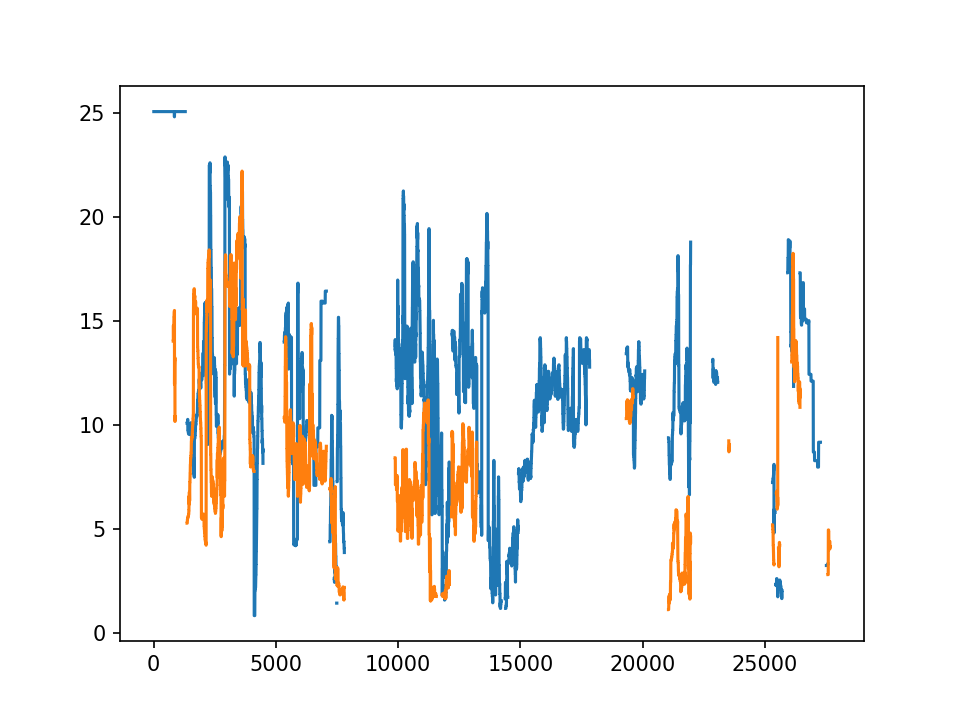

In [273]:
plt.figure()
plt.plot(mod['cod'])
plt.plot(myd['cod'])

### Get the fit to sine function
Following Min & Zhang,2014 function for cloud fraction diurnal cycle 

$COD(t) = A sin(\frac{\pi(t+\phi)}{12})+B$

With local max at 6:50 am (for cloud fraction but applied to COD), giving $\phi=-0.96$

For two points, we get to solve for A and B:  

$A = \frac{COD_2(t_2)-COD_1(t_1)}{sin(\frac{\pi(t_2+\phi)}{12})-sin(\frac{\pi(t_1+\phi)}{12})}$
  
and 

$B = COD_1(t_1) - \frac{COD_2(t_2)-COD_1(t_1)}{sin(\frac{\pi(t_2+\phi)}{12})-sin(\frac{\pi(t_1+\phi)}{12})} sin(\frac{\pi(t_1+\phi)}{12})$
  
Do the same for ref 


In [58]:
def fit_sine(f1,f2,t1,t2):
    'get the fitted values for the sine wave f1 anf f2 are either cod or ref, t1 and t2 are the times in hours'
    phi = -0.96
    A = (f2-f1) / (np.sin(np.pi*(t2+phi)/12.0) - np.sin(np.pi*(t1+phi)/12.0))
    B = f1 - A*np.sin(np.pi*(t1+phi)/12.0)
    return A,B

In [59]:
def get_sines(A,B,f0,t0,utcs=np.arange(0,24.0,0.5),val_range=[0,100]):
    phi = -0.96
    fbs = A*np.sin(np.pi*(utcs+phi)/12.0)+B
    fb0 = A*np.sin(np.pi*(t0+phi)/12.0)+B
    fb_frac = fb0/f0
    new_f = fbs/fb_frac
    if any(new_f<0):
        new_f = new_f+abs(np.nanmin(new_f))
    if np.nanmax(new_f)>val_range[1]:
        frac_fit = val_range[1]/np.nanmax(new_f)
        #print 'fract_fit: ',frac_fit
        new_f = get_sines(A*frac_fit,B+frac_fit,f0,t0,utcs=utcs,val_range=val_range)
    return new_f

Prep for sine fitting (fill out missing values with interp)

In [106]:
mod_cod = np.arange(0,len(mod['time'][iaes]))
myd_cod = np.arange(0,len(myd['time'][iaes]))
fmodcod = interp1d(mod_cod[np.isfinite(mod['cod'][iaes])],mod['cod'][iaes[np.isfinite(mod['cod'][iaes])]],bounds_error=False,kind='linear',fill_value='extrapolate')
fmydcod = interp1d(myd_cod[np.isfinite(myd['cod'][iaes])],myd['cod'][iaes[np.isfinite(myd['cod'][iaes])]],bounds_error=False,kind='linear',fill_value="extrapolate")
mod['codb'] = fmodcod(mod_cod)
myd['codb'] = fmydcod(myd_cod)

In [107]:
mod_ref = np.arange(0,len(mod['time'][iaes]))
myd_ref = np.arange(0,len(myd['time'][iaes]))
fmodref = interp1d(mod_ref[np.isfinite(mod['ref'][iaes])],mod['ref'][iaes[np.isfinite(mod['ref'][iaes])]],bounds_error=False,kind='linear',fill_value='extrapolate')
fmydref = interp1d(myd_ref[np.isfinite(myd['ref'][iaes])],myd['ref'][iaes[np.isfinite(myd['ref'][iaes])]],bounds_error=False,kind='linear',fill_value="extrapolate")
mod['refb'] = fmodref(mod_ref)
myd['refb'] = fmydref(myd_ref)

In [108]:
A_cod,B_cod = fit_sine(mod['codb'],myd['codb'],mod['time'][iaes],myd['time'][iaes])
A_ref,B_ref = fit_sine(mod['refb'],myd['refb'],mod['time'][iaes],myd['time'][iaes])

#### Save

In [113]:
diurn = {'A_cod':A_cod,'B_cod':B_cod,'A_ref':A_ref,'B_ref':B_ref,'utcs':np.arange(0,24,0.5),'iaes':iaes}

In [114]:
sio.savemat(fp+'data_other/MODIS/MODIS_ORACLES2016_match.mat',{'mod':mod,'myd':myd,'diurn':diurn})

#### Load

In [43]:
ddiurn = sio.loadmat(fp+'data_other/MODIS/MODIS_ORACLES2016_match.mat')

In [44]:
ddiurn.keys()

['__header__', '__globals__', 'mod', '__version__', 'myd', 'diurn']

In [45]:
def revert_from_mat(m):
    for k in m.dtype.names:
        if len(m[k])==1:
            m[k] = m[k][0,0]
    return m

In [46]:
mod = ddiurn['mod']
myd = ddiurn['myd']
diurn = ddiurn['diurn']

In [47]:
mod = revert_from_mat(ddiurn['mod'])
myd = revert_from_mat(ddiurn['myd'])
diurn = revert_from_mat(ddiurn['diurn'])

ValueError: could not broadcast input array from shape (1,20284) into shape (1,1)

In [48]:
A_cod, B_cod, A_ref, B_ref, iaes = diurn['A_cod'][0,0].flatten(),diurn['B_cod'][0,0].flatten(),\
                                    diurn['A_ref'][0,0].flatten(),diurn['B_ref'][0,0].flatten(),diurn['iaes'][0,0].flatten()

In [49]:
A_cod

array([15.44126827, 15.44126827, 15.44126827, ..., -0.65644355,
       -0.73080352, -0.73080352])

In [50]:
len(A_cod),len(mod['lat']),len(iaes)

(20284, 1, 20284)

In [51]:
len(ddiurn['mod'])

1

In [52]:
mod.dtype.names

('codb', 'mask', 'lon', 'qa', 'cod', 'time', 'lat', 'refb', 'ref')

#### plot

<IPython.core.display.Javascript object>


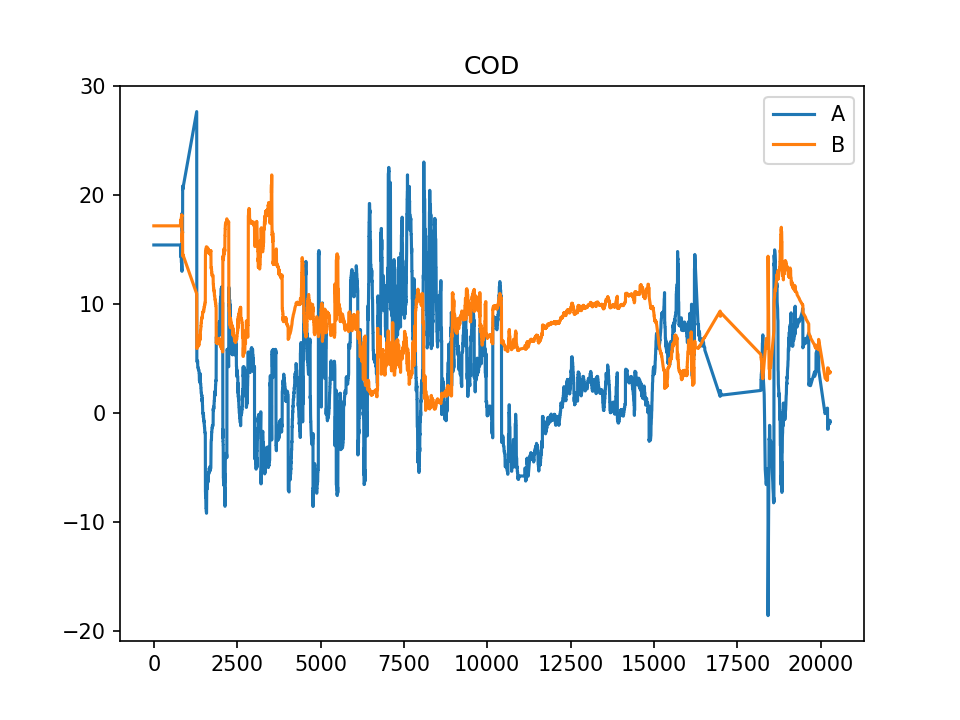

<IPython.core.display.Javascript object>


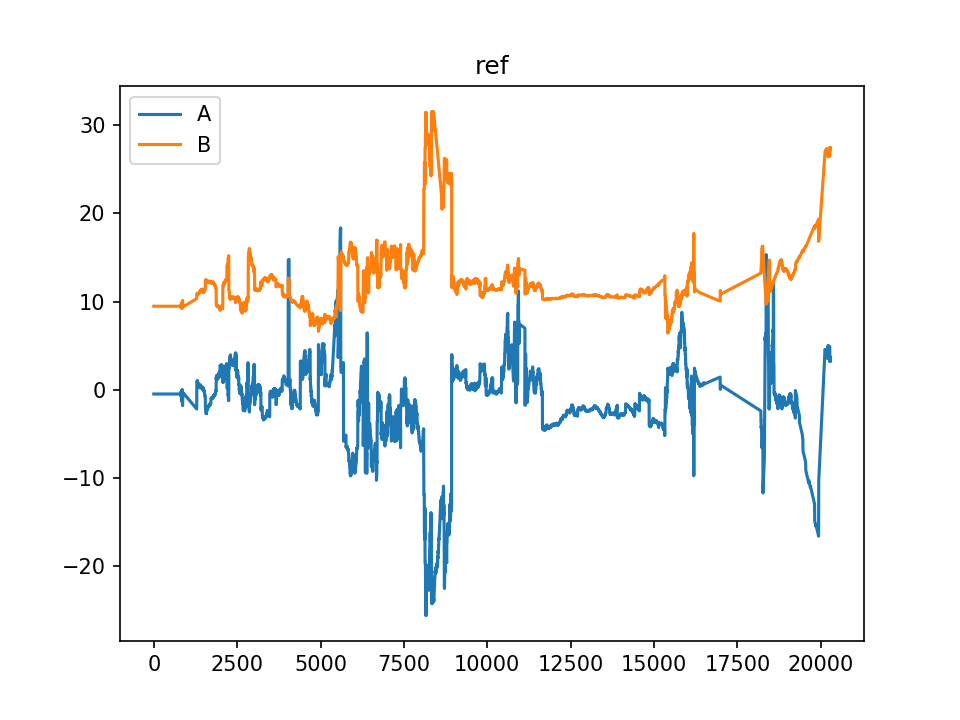

Text(0.5,1,'ref')

In [51]:
plt.figure()
plt.plot(A_cod,label='A')
plt.plot(B_cod,label='B')
plt.title('COD')
plt.legend()
plt.figure()
plt.plot(A_ref,label='A')
plt.plot(B_ref,label='B')
plt.legend()
plt.title('ref')

 Fill out the values to not have NaN

In [53]:
x_cod = np.arange(0,len(A_cod))
fAcod = interp1d(x_cod[np.isfinite(A_cod)],A_cod[np.isfinite(A_cod)],bounds_error=False,kind='linear',fill_value='extrapolate')
fBcod = interp1d(x_cod[np.isfinite(A_cod)],B_cod[np.isfinite(A_cod)],bounds_error=False,kind='linear',fill_value="extrapolate")
A_codb = fAcod(x_cod)
B_codb = fBcod(x_cod)

In [54]:
x_ref = np.arange(0,len(A_ref))
fAref = interp1d(x_ref[np.isfinite(A_ref)],A_ref[np.isfinite(A_ref)],bounds_error=False,kind='linear',fill_value='extrapolate')
fBref = interp1d(x_ref[np.isfinite(A_ref)],B_ref[np.isfinite(A_ref)],bounds_error=False,kind='linear',fill_value="extrapolate")
A_refb = fAref(x_ref)
B_refb = fBref(x_ref)

In [55]:
if not 'fla' in locals():
    # for all 4STAR aerosol arrays
    fla = (ar['flag_acaod']==1) & ar['fl'] & ar['fl_QA'] & (ar['days']>2.0) 

In [56]:
if not 'flb' in locals():
    # for the cod and ref arrays
    fld = (ar['days']>2.0) & (ar['days']!=17.0) 
    flb = (ar['flag_acaod'][fld]==1) & ar['fl'][fld] & ar['fl_QA'][fld]

In [60]:
# test
i = 0
print cod[flb][iaes][i],ref[flb][iaes][i],ar['Start_UTC'][fla][iaes][i],A_cod[i],B_cod[i]
get_sines(A_cod[i],B_cod[i],cod[flb][iaes][i],ar['Start_UTC'][fla][iaes][i])

12.5 4.25 8.703888888888889 15.44126827125967 17.19649216501383


array([ 5.3758919 ,  6.17485422,  6.98659201,  7.79721623,  8.59285687,
        9.35990028, 10.08522215, 10.75641202, 11.36198565, 11.89158149,
       12.33613803, 12.68804877, 12.94129242, 13.09153592, 13.13620855,
       13.07454596, 12.90760321, 12.63823674, 12.27105547, 11.81234199,
       11.26994501, 10.6531451 ,  9.97249586,  9.2396434 ,  8.46712702,
        7.6681647 ,  6.8564269 ,  6.04580269,  5.25016205,  4.48311864,
        3.75779677,  3.08660689,  2.48103327,  1.95143742,  1.50688089,
        1.15497015,  0.9017265 ,  0.751483  ,  0.70681037,  0.76847296,
        0.93541571,  1.20478218,  1.57196344,  2.03067692,  2.5730739 ,
        3.18987382,  3.87052306,  4.60337552])

In [61]:
get_sines(A_ref[i],B_ref[i],ref[flb][iaes][i],ar['Start_UTC'][fla][iaes][i])

array([4.51312888, 4.48361922, 4.45363769, 4.42369729, 4.39431031,
       4.36597956, 4.3391898 , 4.31439941, 4.29203255, 4.27247193,
       4.25605224, 4.24305442, 4.23370087, 4.22815162, 4.22650164,
       4.22877915, 4.23494518, 4.24489423, 4.25845606, 4.27539864,
       4.29543207, 4.31821357, 4.34335335, 4.37042125, 4.39895414,
       4.4284638 , 4.45844533, 4.48838573, 4.51777272, 4.54610346,
       4.57289322, 4.59768361, 4.62005047, 4.63961109, 4.65603078,
       4.6690286 , 4.67838215, 4.6839314 , 4.68558138, 4.68330387,
       4.67713784, 4.66718879, 4.65362696, 4.63668438, 4.61665095,
       4.59386945, 4.56872967, 4.54166177])

### Run through the modis match multidimensional (old)

In [ ]:
if False:
    if isjupyter():
        pbar = tqdm(total=nval)
    for i,u in enumerate(ar['Start_UTC'][fla]):
        if i<22760: 
            pbar.update(1)
            continue
        iae = np.argmin(abs(ar['time_ae'][fla][i]-ae['time']/3600.0))
        if abs(ar['time_ae'][fla][i]-ae['time']/3600.0)[iae]<1.0: 
            ad = '{}'.format(ar['doy'][fla][i])
            for igo,go in enumerate(geoso[ad]['fh']):
                ix,iy = np.unravel_index(np.argmin(abs(geoso[ad]['lat'][igo,:,:]-ar['Latitude'][fla][i])+
                            abs(geoso[ad]['lon'][igo,:,:]-ar['Longitude'][fla][i])),geoso[ad]['lon'][igo,:,:].shape)
                if (abs(geoso[ad]['lat'][igo,ix,iy]-ar['Latitude'][fla][i])<0.1) &\
                   (abs(geoso[ad]['lon'][igo,ix,iy]-ar['Longitude'][fla][i])<0.1):
                    try:
                        cod,ref,qa = read_mod06_hdf_pixel(go,ix,iy)
                        if mod_qa(qa): 
                            mod['cod'][i] = cod
                            mod['ref'][i] = ref
                            mod['time'][i] = geoso[ad]['time'][igo]
                    except:
                        pass
            for igy,gy in enumerate(geosy[ad]['fh']):
                ix,iy = np.unravel_index(np.argmin(abs(geosy[ad]['lat'][igy,:,:]-ar['Latitude'][fla][i])+
                            abs(geosy[ad]['lon'][igy,:,:]-ar['Longitude'][fla][i])),geosy[ad]['lon'][igy,:,:].shape)
                if (abs(geosy[ad]['lat'][igy,ix,iy]-ar['Latitude'][fla][i])<0.1) &\
                   (abs(geosy[ad]['lon'][igy,ix,iy]-ar['Longitude'][fla][i])<0.1):
                    try:
                        cody,refy,qay = read_mod06_hdf_pixel(gy,ix,iy)
                        if mod_qa(qay):
                            myd['cod'][i] = cody
                            myd['ref'][i] = refy
                            myd['time'][i] = geosy[ad]['time'][igy]
                    except:
                        pass
        pbar.update(1)

In [68]:
class KeyboardInterruptError(Exception): pass

In [574]:
def get_modis_val(i):
    m = {'ocod':np.nan,'oref':np.nan,'omask':np.nan,'otime':np.nan,
         'ycod':np.nan,'yref':np.nan,'ymask':np.nan,'ytime':np.nan}
    iae = np.argmin(abs(ar['time_ae'][fla][i]-ae['time']/3600.0))
    if abs(ar['time_ae'][fla][i]-ae['time']/3600.0)[iae]<1.0: 
        ad = '{}'.format(ar['doy'][fla][i])
        for igo,go in enumerate(geoso[ad]['fh']):
            ix,iy = np.unravel_index(np.argmin(abs(geoso[ad]['lat'][igo,:,:]-ar['Latitude'][fla][i])+
                        abs(geoso[ad]['lon'][igo,:,:]-ar['Longitude'][fla][i])),geoso[ad]['lon'][igo,:,:].shape)
            if (abs(geoso[ad]['lat'][igo,ix,iy]-ar['Latitude'][fla][i])<0.02) &\
               (abs(geoso[ad]['lon'][igo,ix,iy]-ar['Longitude'][fla][i])<0.02):
                cod,ref,qa = read_mod06_hdf_pixel(go,ix,iy)
                if mod_qa(qa):
                    try: 
                        m['ocod'] = cod
                        m['oref'] = ref
                    except:
                        pass
                    m['otime'] = geoso[ad]['time'][igo]
        for igy,gy in enumerate(geosy[ad]['fh']):
            ix,iy = np.unravel_index(np.argmin(abs(geosy[ad]['lat'][igy,:,:]-ar['Latitude'][fla][i])+
                        abs(geosy[ad]['lon'][igy,:,:]-ar['Longitude'][fla][i])),geosy[ad]['lon'][igy,:,:].shape)
            if (abs(geosy[ad]['lat'][igy,ix,iy]-ar['Latitude'][fla][i])<0.02) &\
               (abs(geosy[ad]['lon'][igy,ix,iy]-ar['Longitude'][fla][i])<0.02):
                cody,refy,qay = read_mod06_hdf_pixel(gy,ix,iy)
                if mod_qa(qay):
                    try:
                        m['ycod'] = cody
                        m['yref'] = refy
                    except:
                        pass
                    m['ytime'] = geosy[ad]['time'][igy]

signal: 2
signal: 2
signal: 2
signal: 2


In [575]:
def worker_init(verbose=True):
    # ignore the SIGINI in sub process, just print a log
    def sig_int(signal_num, frame):
        if verbose: 
            print 'signal: %s' % signal_num
        raise IOError
    signal.signal(signal.SIGINT, sig_int)

signal: 2
signal: 2
signal: 2


In [ ]:
p = Pool(cpu_count()-1,worker_init)

In [ ]:
mod_outputs = []
max_ = len(ar['Start_UTC'][fla])
with tqdm(total=max_) as pbar:
    for i, outs in tqdm(enumerate(p.imap_unordered(get_modis_val, range(0, max_)))):
        pbar.update()
        mod_outputs.append(outs)

In [318]:
cod[flb]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2030 but corresponding boolean dimension is 379755

# Prepare the base dict and defaults

In [62]:
from datetime import datetime
datetime(2015,11,17).timetuple().tm_yday

321

In [63]:
# for all 4STAR aerosol arrays
fla = (ar['flag_acaod']==1) & ar['fl'] & ar['fl_QA'] & (ar['days']>2.0) 

In [64]:
# for the cod and ref arrays
fld = (ar['days']>2.0) & (ar['days']!=17.0) 
flb = (ar['flag_acaod'][fld]==1) & ar['fl'][fld] & ar['fl_QA'][fld]

In [65]:
len(ar['AOD0355'][fla])

27672

In [66]:
len(cod[flb])

27672

In [67]:
sum(np.isfinite(cod[~flb])),sum(np.isfinite(cod[flb])),len(cod[flb])

(4354, 16327, 27672)

In [68]:
ka = ar.keys()
ka.sort()
ka

[u'AOD0355',
 u'AOD0380',
 u'AOD0452',
 u'AOD0470',
 u'AOD0501',
 u'AOD0520',
 u'AOD0530',
 u'AOD0532',
 u'AOD0550',
 u'AOD0606',
 u'AOD0620',
 u'AOD0660',
 u'AOD0675',
 u'AOD0700',
 u'AOD0781',
 u'AOD0865',
 u'AOD1020',
 u'AOD1040',
 u'AOD1064',
 u'AOD1236',
 u'AOD1250',
 u'AOD1559',
 u'AOD1627',
 u'AOD1650',
 u'AOD_angstrom_470_865',
 u'AOD_polycoef_a0',
 u'AOD_polycoef_a1',
 u'AOD_polycoef_a2',
 u'GPS_Alt',
 u'Latitude',
 u'Longitude',
 u'Start_UTC',
 u'UNCAOD0355',
 u'UNCAOD0380',
 u'UNCAOD0452',
 u'UNCAOD0470',
 u'UNCAOD0501',
 u'UNCAOD0520',
 u'UNCAOD0530',
 u'UNCAOD0532',
 u'UNCAOD0550',
 u'UNCAOD0606',
 u'UNCAOD0620',
 u'UNCAOD0660',
 u'UNCAOD0675',
 u'UNCAOD0700',
 u'UNCAOD0781',
 u'UNCAOD0865',
 u'UNCAOD1020',
 u'UNCAOD1040',
 u'UNCAOD1064',
 u'UNCAOD1236',
 u'UNCAOD1250',
 u'UNCAOD1559',
 u'UNCAOD1627',
 u'UNCAOD1650',
 u'amass_aer',
 u'days',
 'doy',
 u'fl',
 u'fl1',
 u'fl2',
 u'fl3',
 u'fl_QA',
 u'fl_alt',
 u'fl_alt_18',
 u'fl_alt_22',
 u'fl_alt_6',
 u'fl_routine',
 u'flac

In [69]:
doy = datetime.strptime(dds[int(ar['days'][fla][0])],'%Y%m%d').timetuple().tm_yday

In [70]:
doy

250

In [71]:
geo = {'lat':ar['Latitude'][0],'lon':ar['Longitude'][0],'doy':doy,'zout':[0,1.5,100.0]}
aero_no = {} # none
cloud = {'ztop':1.0,'zbot':0.5,'write_moments_file':False}
source = {'wvl_range':[201.0,4900.0],'source':'solar','integrate_values':True,'run_fuliou':True,
          'dat_path':fp_uvspec_dat}
albedo = {'create_albedo_file':False,'sea_surface_albedo':True,'wind_speed':5.0}

In [72]:
cloud['phase'] = 'wc'
geo['sza'] = 40.0
cloud['tau'] = 2.0
cloud['ref'] = 5.0

In [73]:
pmom = Rl.make_pmom_inputs(fp_rtm=fp_rtmdat,source='solar',deltascale=True,new=True)
tw = ['ntheta','rho','ssa','nmom','ext']
th = ['phase','pmom','theta']
on = ['wvl','nim','nre']
pmom_new = {}
for k in pmom.keys():
    if k in tw:
        pmom_new[k] = pmom[k][:,::50]
    elif k in th:
        pmom_new[k] = pmom[k][:,::50,:]
    elif k in on:
        pmom_new[k] = pmom[k][::50]
    else:
        pmom_new[k] = pmom[k]
    
    try:
        print k, pmom_new[k].shape        
    except:
        pass
pmom_new['wvl'][0] = 0.250
pmom_new['wvl'][-1] = 4.900
cloud['moms_dict'] = pmom_new

ntheta (40, 28)
wvl (28,)
nim (28,)
file_name nre (28,)
rho (40, 28)
phase (40, 28, 1500)
ssa (40, 28)
pmom (40, 28, 9000)
nmom (40, 28)
ext (40, 28)
theta (40, 28, 1500)
ref (1, 40)


In [74]:
pmom_new['wvl']

array([0.25, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85,
       0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 ,
       1.45, 1.5 , 1.55, 1.6 , 1.65, 4.9 ])

In [75]:
wvl = np.append(np.append([250.0],ae['wavelength']),4900.0)
wvl

array([ 250.,  400.,  500.,  675.,  870.,  995., 4900.])

In [76]:
aero = {'expand_hg':True,'disort_phase':False,'z_arr':[2.0,5.0],
        'wvl_arr':wvl}

In [77]:
def fx_aero(aprop):
    'Function the aerosol property a 2d matrix for height and spectra, and extend the wavelength from 250 to 4900 nm'
    atmp = np.append([aprop[0]],np.append(aprop,aprop[-1]))
    return np.array([atmp,atmp])

In [78]:
def fx_ext(a0,a1,a2,wvl=wvl):
    'Function to create the extinction coefficients from 4STAR AODs'
    aod = np.exp(np.polyval([a2,a1,a0],np.log(wvl)))
    aod[-1] = 0.0 # set the last wavelength to zero
    return np.array([aod/3.0,aod*0.0])

In [79]:
aero['ext'] = fx_ext(ar['AOD_polycoef_a0'][fla][0],ar['AOD_polycoef_a1'][fla][0],ar['AOD_polycoef_a2'][fla][0])

In [80]:
aero['asy'] = fx_aero(ae['g_total'][0])

In [81]:
aero['ssa'] = fx_aero(ae['SSA'][0])

## Prepare the file list and saving

In [82]:
from path_utils import isjupyter

In [83]:
isjupyter()

True

## Write the files

### Conventional

In [80]:
# open the list file
f = open(fp_rtm+'{}_DARE_{}.sh'.format(name,vv),'w')
fpp_in = fp_rtm+'input/{}_DARE_{}/'.format(name,vv)
fpp_out = fp_rtm+'output/{}_DARE_{}/'.format(name,vv)

In [81]:
if not os.path.isdir(fpp_in):
    os.mkdir(fpp_in)
if not os.path.isdir(fpp_out):
     os.mkdir(fpp_out)

In [120]:
# for writing out the files

In [109]:
ae['time']/3600.0

array([  9.36436349,   9.38314424,  11.44100489,  13.53473135,
        13.55286422,  13.63317105,  13.65609344,  14.15397498,
        14.17291726,  55.12454682,  56.45493072,  56.47428852,
        56.50556153,  56.52408765,  56.62796449,  56.64651974,
        57.3145811 ,  57.57097029,  57.58955459,  58.57214188,
        58.99556736,  60.49512862,  60.51375567,  60.53747322,
        62.83647775, 153.56740963, 153.58586041, 154.09168935,
       154.11113343, 154.98052584, 155.82233424, 155.84067681,
       156.42516806, 156.44378445, 157.14872684, 157.16740038,
       203.2280269 , 251.08488591, 252.31515166, 300.24803314,
       301.14747711, 301.1660435 , 301.18294843, 301.7608256 ,
       301.77941441, 302.12064148, 302.14029531, 345.31344008,
       345.33189656, 346.52380833, 346.63178176, 346.6632354 ,
       349.91946379, 441.84949381, 489.40488159, 489.42472078,
       489.45796597, 489.48503416, 489.52466494, 489.55642007,
       489.58136179, 491.02055947, 491.14471216, 492.66

In [110]:
ar['time_ae'][fla]

array([  7.95472222,   7.955     ,   7.95527778, ..., 665.405     ,
       665.40527778, 665.40555556])

In [82]:
if isjupyter():
    pbar = tqdm(total=len(ar['Start_UTC'][fla]))
for i,u in enumerate(ar['Start_UTC'][fla]):
    
    f_in = '{name}_{vv}_DARE_{i:03d}_withaero.dat'.format(name=name,vv=vv,i=i)

    geo['lat'],geo['lon'],geo['sza'] = ar['Latitude'][fla][i],ar['Longitude'][fla][i],sza[fla][i]
    day = days[ar['days'][fla][i].astype(int)]
    geo['doy'] = datetime(int(day[0:4]),int(day[4:6]),int(day[6:])).timetuple().tm_yday

    cloud['tau'],cloud['ref'] = cod[flb][i],ref[flb][i]
    cloud['write_moments_file'] = True

    iae = np.argmin(abs(ar['time_ae'][fla][i]-ae['time']/3600.0))

    # Only run for aerosol rertievals within 1 hour
    if abs(ar['time_ae'][fla][i]-ae['time']/3600.0)[iae]<1.0: 

        aero['ext'] = fx_ext(ar['AOD_polycoef_a0'][fla][i],ar['AOD_polycoef_a1'][fla][i],ar['AOD_polycoef_a2'][fla][i])
        aero['ssa'] = fx_aero(ae['SSA'][iae])
        aero['asy'] = fx_aero(ae['g_total'][iae])

        Rl.write_input_aac(fpp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                                   verbose=False,make_base=False,set_quiet=True)
        f.write('{uv} < {fin} > {out}\n'.format(uv=fp_uvspec,fin=fpp_in+f_in,out=fpp_out+f_in))

        f_in = '{name}_{vv}_star_{i:03d}_noaero.dat'.format(name=name,vv=vv,i=i)
        Rl.write_input_aac(fpp_in+f_in,geo=geo,aero=aero_no,cloud=cloud,source=source,albedo=albedo,
                                   verbose=False,make_base=False,set_quiet=True)
        f.write('{uv} < {fin} > {out}\n'.format(uv=fp_uvspec,fin=fpp_in+f_in,out=fpp_out+f_in))

    if isjupyter(): 
        pbar.update(1)
    else:
        print i

f.close()

A Jupyter Widget

> /home/sam/python_codes/Run_libradtran.py(485)write_cloud_file_moments_wvl()
-> for iw,wv in enumerate(wvl):
(Pdb) q


BdbQuit: 

### Multiprocessing

In [146]:
def worker_init(verbose=True):
    # ignore the SIGINI in sub process, just print a log
    def sig_int(signal_num, frame):
        if verbose: 
            print 'signal: %s' % signal_num
        raise IOError
    signal.signal(signal.SIGINT, sig_int)

In [60]:
# open the list file
f = open(fp_rtm+'{}_DARE_{}.sh'.format(name,vv),'w')
fpp_in = fp_rtm+'input/{}_DARE_{}/'.format(name,vv)
fpp_out = fp_rtm+'output/{}_DARE_{}/'.format(name,vv)

In [148]:
if not os.path.isdir(fpp_in):
    os.mkdir(fpp_in)
if not os.path.isdir(fpp_out):
     os.mkdir(fpp_out)

In [149]:
if isjupyter():
    pbar = tqdm(total=len(ar['Start_UTC'][fla]))
bb = []
for i,u in enumerate(ar['Start_UTC'][fla]):
    
    f_in = '{name}_{vv}_DARE_{i:03d}_withaero.dat'.format(name=name,vv=vv,i=i)

    geo['lat'],geo['lon'],geo['sza'] = ar['Latitude'][fla][i],ar['Longitude'][fla][i],sza[fla][i]
    day = days[ar['days'][fla][i].astype(int)]
    geo['doy'] = datetime(int(day[0:4]),int(day[4:6]),int(day[6:])).timetuple().tm_yday

    if ~np.isfinite(cod[flb][i]):
        if isjupyter():
            pbar.update(1)
        continue
    cloud['tau'],cloud['ref'] = cod[flb][i],ref[flb][i]
    cloud['write_moments_file'] = True

    iae = np.argmin(abs(ar['time_ae'][fla][i]-ae['time']/3600.0))

    # Only run for aerosol rertievals within 1 hour
    if abs(ar['time_ae'][fla][i]-ae['time']/3600.0)[iae]<1.0: 

        aero['ext'] = fx_ext(ar['AOD_polycoef_a0'][fla][i],ar['AOD_polycoef_a1'][fla][i],ar['AOD_polycoef_a2'][fla][i])
        aero['ssa'] = fx_aero(ae['SSA'][iae])
        aero['asy'] = fx_aero(ae['g_total'][iae])

        #Rl.write_input_aac(fpp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
        #                           verbose=False,make_base=False,set_quiet=True)
        f.write('{uv} < {fin} > {out}\n'.format(uv=fp_uvspec,fin=fpp_in+f_in,out=fpp_out+f_in))

        f_in_noa = '{name}_{vv}_star_{i:03d}_noaero.dat'.format(name=name,vv=vv,i=i)
        #Rl.write_input_aac(fpp_in+f_in,geo=geo,aero=aero_no,cloud=cloud,source=source,albedo=albedo,
        #                           verbose=False,make_base=False,set_quiet=True)
        f.write('{uv} < {fin} > {out}\n'.format(uv=fp_uvspec,fin=fpp_in+f_in_noa,out=fpp_out+f_in_noa))
        
        bb.append({'geo':deepcopy(geo),'cod':cod[flb][i],'ref':ref[flb][i],'aero':deepcopy(aero),
                   'f_in':deepcopy(f_in),'f_in_noa':deepcopy(f_in_noa)})

    if isjupyter(): 
        pbar.update(1)
    else:
        print i

f.close()

A Jupyter Widget

In [150]:
def write_files(d,cloud=cloud,source=source,albedo=albedo,aero_no=aero_no):
    'function to feed the pool of workers to write out the all the files'
    cloud['tau'],cloud['ref'] = d['cod'],d['ref']
    Rl.write_input_aac(fpp_in+d['f_in'],geo=d['geo'],aero=d['aero'],cloud=cloud,source=source,albedo=albedo,
                                   verbose=False,make_base=False,set_quiet=True)
    Rl.write_input_aac(fpp_in+d['f_in_noa'],geo=d['geo'],aero=aero_no,cloud=cloud,source=source,albedo=albedo,
                                   verbose=False,make_base=False,set_quiet=True)

In [151]:
p = Pool(cpu_count()-1,worker_init)

signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2

Process PoolWorker-127:
Process PoolWorker-137:
Process PoolWorker-132:
Process PoolWorker-139:
Process PoolWorker-126:
Process PoolWorker-121:
Process PoolWorker-120:
Process PoolWorker-130:
Process PoolWorker-128:
Process PoolWorker-131:
Process PoolWorker-122:
Process PoolWorker-124:
Process PoolWorker-129:
Process PoolWorker-136:
Process PoolWorker-140:
Process PoolWorker-133:
Process PoolWorker-134:
Process PoolWorker-138:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Tracebac

    rrelease()
    rrelease()
ValueError: semaphore or lock released too many times
    rrelease()
    rrelease()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get
    self._target(*self._args, **self._kwargs)
ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times
    rrelease()
    rrelease()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get
    rrelease()
ValueError: semaphore or lock released too many times
    rrelease()
    rrelease()
ValueError: semaphore or lock released too many times
    rrelease()
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    rrelease()
ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times


signal: 2

ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    rrelease()


signal: 2signal: 2

    rrelease()
ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times


signal: 2

ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times


signal: 2

    task = get()
ValueError: semaphore or lock released too many times


signal: 2signal: 2signal: 2signal: 2signal: 2

  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get


signal: 2

ValueError: semaphore or lock released too many times
    task = get()


signal: 2signal: 2signal: 2

ValueError: semaphore or lock released too many times


signal: 2signal: 2

Process PoolWorker-125:
    rrelease()


signal: 2

  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get


signal: 2

Traceback (most recent call last):
ValueError: semaphore or lock released too many times
    rrelease()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap


signal: 2

ValueError: semaphore or lock released too many times
    self.run()


signal: 2

  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get
    rrelease()
ValueError: semaphore or lock released too many times


signal: 2

In [152]:
len(bb)

13551

In [153]:
results = []
max_ = len(bb)
with tqdm(total=max_) as pbar:
    for i, res in tqdm(enumerate(p.imap_unordered(write_files, bb))):
        pbar.update()
        results.append(res)

A Jupyter Widget

A Jupyter Widget

In [257]:
results = p.map(write_files,bb)

### Diurnal averaging with multiprocessing

In [106]:
if vv=='v3':
    vvh = 'v3_24h'
    dssa = 0.0
elif vv =='v4':
    vvh = 'v4_24h'
    dssa = 0.0
elif vv == 'v5':
    vvh = 'v5_aodp'
print vv,vvh

v5 v5_aodp


In [107]:
dssa = 0.0
dasy = 0.0
daod = 0.0


if vvh == 'v5_ssam': dssa = -0.03
elif vvh == 'v5_ssap': dssa = 0.03
elif vvh == 'v5_asym': dasy = -0.03
elif vvh == 'v5_asyp': dasy = 0.03
elif vvh == 'v5_aodm': daod = -0.03
elif vvh == 'v5_aodp': daod = 0.03
daod,dssa,dasy

(0.03, 0.0, 0.0)

In [108]:
vvh = vvh+'_diurnal' # for the version with diurnal cycles from MODIS

In [109]:
print vvh

v5_aodp_diurnal


In [110]:
def worker_init(verbose=True):
    # ignore the SIGINI in sub process, just print a log
    def sig_int(signal_num, frame):
        if verbose: 
            print 'signal: %s' % signal_num
        raise IOError
    signal.signal(signal.SIGINT, sig_int)

In [111]:
# open the list file
f = open(fp_rtm+'{}_DARE_{}.sh'.format(name,vvh),'w')
fpp_in = fp_rtm+'input/{}_DARE_{}/'.format(name,vvh)
fpp_out = fp_rtm+'output/{}_DARE_{}/'.format(name,vvh)

In [112]:
if not os.path.isdir(fpp_in):
    os.mkdir(fpp_in)
if not os.path.isdir(fpp_out):
     os.mkdir(fpp_out)

In [113]:
if isjupyter():
    pbar = tqdm(total=len(ar['Start_UTC'][fla]))
bb = []
ii = 0 
for i,u in enumerate(ar['Start_UTC'][fla]):
    
    f_in = '{name}_{vv}_DARE_{i:03d}_withaero.dat'.format(name=name,vv=vvh,i=i)

    geo['lat'],geo['lon'],geo['sza'] = ar['Latitude'][fla][i],ar['Longitude'][fla][i],sza[fla][i]
    day = days[ar['days'][fla][i].astype(int)]
    geo['doy'] = datetime(int(day[0:4]),int(day[4:6]),int(day[6:])).timetuple().tm_yday

    if ~np.isfinite(cod[flb][i]):
        if isjupyter():
            pbar.update(1)
        continue
    cloud['tau'],cloud['ref'] = cod[flb][i],ref[flb][i]
    cloud['write_moments_file'] = True

    iae = np.argmin(abs(ar['time_ae'][fla][i]-ae['time']/3600.0))

    # Only run for aerosol rertievals within 1 hour
    if abs(ar['time_ae'][fla][i]-ae['time']/3600.0)[iae]<1.0: 

        aero['ext'] = fx_ext(ar['AOD_polycoef_a0'][fla][i],ar['AOD_polycoef_a1'][fla][i],ar['AOD_polycoef_a2'][fla][i])+daod
        try: aero['ext'][aero['ext']<0.0] = 0.0
        except: pass
        aero['ssa'] = fx_aero(ae['SSA'][iae])+dssa
        try: aero['ssa'][aero['ssa']>1.0] = 1.0
        except: pass
        try: aero['ssa'][aero['ssa']<0.0] = 0.0
        except: pass
        aero['asy'] = fx_aero(ae['g_total'][iae])+dasy
        try: aero['asy'][aero['asy']>1.0] = 1.0
        except: pass
        try: aero['asy'][aero['asy']<0.0] = 0.0
        except: pass

        #Rl.write_input_aac(fpp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
        #                           verbose=False,make_base=False,set_quiet=True)
        f.write('{uv} < {fin} > {out}\n'.format(uv=fp_uvspec,fin=fpp_in+f_in,out=fpp_out+f_in))

        f_in_noa = '{name}_{vv}_star_{i:03d}_noaero.dat'.format(name=name,vv=vvh,i=i)
        #Rl.write_input_aac(fpp_in+f_in,geo=geo,aero=aero_no,cloud=cloud,source=source,albedo=albedo,
        #                           verbose=False,make_base=False,set_quiet=True)
        f.write('{uv} < {fin} > {out}\n'.format(uv=fp_uvspec,fin=fpp_in+f_in_noa,out=fpp_out+f_in_noa))
        
        bb.append({'geo':deepcopy(geo),'cod':cod[flb][i],'ref':ref[flb][i],'aero':deepcopy(aero),
                   'f_in':deepcopy(f_in),'f_in_noa':deepcopy(f_in_noa),
                   'A_cod':A_cod[ii],'B_cod':B_cod[ii],'A_ref':A_ref[ii],'B_ref':B_ref[ii],'UTC':ar['Start_UTC'][fla][i]})
        ii = ii+1

    if isjupyter(): 
        pbar.update(1)
    else:
        print i

f.close()

In [114]:
# Go through and write out the list file for 24 h
f = open(fp_rtm+'{}_DARE_{}.sh'.format(name,vvh),'w')
if isjupyter():
    pbar = tqdm(total=len(ar['Start_UTC'][fla]))
errlog = fp_rtm+'{}_DARE_{}_error.log'.format(name,vvh)
for i,u in enumerate(ar['Start_UTC'][fla]):
    if ~np.isfinite(cod[flb][i]):
        if isjupyter():
            pbar.update(1)
        continue
    iae = np.argmin(abs(ar['time_ae'][fla][i]-ae['time']/3600.0))
    if abs(ar['time_ae'][fla][i]-ae['time']/3600.0)[iae]<1.0: 
        for ux in np.arange(0,24,0.5):
            f_in = '{name}_{vv}_DARE_{i:03d}_withaero_{ux:04.1f}.dat'.format(name=name,vv=vvh,i=i,ux=ux)
            f_in_noa = '{name}_{vv}_star_{i:03d}_noaero_{ux:04.1f}.dat'.format(name=name,vv=vvh,i=i,ux=ux)
            f.write('{uv} < {fin} > {out} 2>> {err}\n'.format(uv=fp_uvspec,fin=fpp_in+f_in,out=fpp_out+f_in,err=errlog))
            f.write('{uv} < {fin} > {out} 2>> {err}\n'.format(uv=fp_uvspec,fin=fpp_in+f_in_noa,out=fpp_out+f_in_noa,err=errlog))
    pbar.update(1)  
f.close()

In [115]:
fp_rtm+'{}_DARE_{}.sh'.format(name,vvh)

u'/scratch/rtm/ORACLES_DARE_v5_aodp_diurnal.sh'

In [116]:
def write_files(d,cloud=cloud,source=source,albedo=albedo,aero_no=aero_no):
    'function to feed the pool of workers to write out the all the files'
    cloud['tau'],cloud['ref'] = d['cod'],d['ref']
    d['f_in'] = d['f_in'].replace('.dat','')+'_{ux:04.1f}.dat'
    d['f_in_noa'] = d['f_in_noa'].replace('.dat','')+'_{ux:04.1f}.dat'
    for ux in np.arange(0,24,0.5):
        d['geo']['utc'] = ux
        d['geo']['hour'] = int(ux)
        d['geo']['minute'] = int((ux-int(ux))*60.0)
        d['geo']['second'] = 0
        d['geo'].pop('sza',None)
        Rl.write_input_aac(fpp_in+d['f_in'].format(ux=ux),geo=d['geo'],aero=d['aero'],cloud=cloud,source=source,albedo=albedo,
                                   verbose=False,make_base=False,set_quiet=True)
        Rl.write_input_aac(fpp_in+d['f_in_noa'].format(ux=ux),geo=d['geo'],aero=aero_no,cloud=cloud,source=source,albedo=albedo,
                                   verbose=False,make_base=False,set_quiet=True)

In [117]:
from datetime import datetime, timedelta
ud = datetime(2016,1,1) + timedelta(bb[0]['geo']['doy'])
bb[0]['geo']['doy']

244

In [118]:
timedelta()

datetime.timedelta(0)

In [119]:
ud.month

9

In [120]:
len(bb)

13551

In [121]:
def write_files(d,cloud=cloud,source=source,albedo=albedo,aero_no=aero_no):
    'function to feed the pool of workers to write out the all the files'
    cloud['tau'],cloud['ref'] = d['cod'],d['ref']
    d['f_in'] = d['f_in'].replace('.dat','')+'_{ux:04.1f}.dat'
    d['f_in_noa'] = d['f_in_noa'].replace('.dat','')+'_{ux:04.1f}.dat'
    ud = datetime.datetime(2016,1,1) + datetime.timedelta(d['geo']['doy'])
    d['geo']['day'] = ud.day
    d['geo']['year'] = ud.year
    d['geo']['month'] = ud.month
    for ux in np.arange(0,24,0.5):
        d['geo']['utc'] = ux
        d['geo']['hour'] = int(ux)
        d['geo']['minute'] = int((ux-int(ux))*60.0)
        d['geo']['second'] = 0
        d['geo'].pop('sza',None)
        Rl.write_input_aac(fpp_in+d['f_in'].format(ux=ux),geo=d['geo'],aero=d['aero'],cloud=cloud,source=source,albedo=albedo,
                                   verbose=False,make_base=False,set_quiet=True)
        Rl.write_input_aac(fpp_in+d['f_in_noa'].format(ux=ux),geo=d['geo'],aero=aero_no,cloud=cloud,source=source,albedo=albedo,
                                   verbose=False,make_base=False,set_quiet=True)

In [122]:
def write_files_sub(d,cloud=cloud,source=source,albedo=albedo,aero_no=aero_no):
    'function to feed the pool of workers to write out the all the files'
    cloud['tau'],cloud['ref'] = d['cod'],d['ref']
    d['f_in'] = d['f_in'].replace('.dat','')+'_{ux:04.1f}.dat'
    d['f_in_noa'] = d['f_in_noa'].replace('.dat','')+'_{ux:04.1f}.dat'
    ud = datetime(2016,1,1) + timedelta(d['geo']['doy'])
    d['geo']['day'] = ud.day
    d['geo']['year'] = ud.year
    d['geo']['month'] = ud.month
    source['run_fuliou'] = True
    d['aero']['link_to_mom_file'] = False
    d['aero']['file_name'] = fpp_in+d['f_in'].format(ux=0.0)+'_aero'
    cloud['link_to_mom_file'] = False
    cloud['file_name'] = fpp_in+d['f_in'].format(ux=0.0)+'_cloud'
    d['geo'].pop('doy',None)
    for ux in np.arange(0,24,0.5):
        d['geo']['utc'] = ux
        d['geo']['hour'] = int(ux)
        d['geo']['minute'] = int((ux-int(ux))*60.0)
        d['geo']['second'] = 0
        d['geo'].pop('sza',None)
        Rl.write_input_aac(fpp_in+d['f_in'].format(ux=ux),geo=d['geo'],aero=d['aero'],cloud=cloud,
                           source=source,albedo=albedo,solver='twostr',
                           verbose=False,make_base=False,set_quiet=True)
        Rl.write_input_aac(fpp_in+d['f_in_noa'].format(ux=ux),geo=d['geo'],aero=aero_no,cloud=cloud,
                           source=source,albedo=albedo,solver='twostr',
                           verbose=False,make_base=False,set_quiet=True)
        cloud['link_to_mom_file'] = True
        d['aero']['link_to_mom_file'] = True

In [123]:
def write_files_sub_diurn(d,cloud=cloud,source=source,albedo=albedo,aero_no=aero_no):
    'function to feed the pool of workers to write out the all the files'
    cloud['tau'],cloud['ref'] = d['cod'],d['ref']
    d['f_in'] = d['f_in'].replace('.dat','')+'_{ux:04.1f}.dat'
    d['f_in_noa'] = d['f_in_noa'].replace('.dat','')+'_{ux:04.1f}.dat'
    ud = datetime(2016,1,1) + timedelta(d['geo']['doy'])
    d['geo']['day'] = ud.day
    d['geo']['year'] = ud.year
    d['geo']['month'] = ud.month
    source['run_fuliou'] = True
    d['aero']['link_to_mom_file'] = False
    d['aero']['file_name'] = fpp_in+d['f_in'].format(ux=0.0)+'_aero'
    cloud['link_to_mom_file'] = False
    cloud['file_name'] = fpp_in+d['f_in'].format(ux=0.0)+'_cloud'
    d['geo'].pop('doy',None)
    cods = get_sines(d['A_cod'],d['B_cod'],d['cod'],d['UTC'])
    refs = get_sines(d['A_ref'],d['B_ref'],d['ref'],d['UTC'])
    for iux,ux in enumerate(np.arange(0,24,0.5)):
        d['geo']['utc'] = ux
        d['geo']['hour'] = int(ux)
        d['geo']['minute'] = int((ux-int(ux))*60.0)
        d['geo']['second'] = 0
        d['geo'].pop('sza',None)
        cloud['tau'],cloud['ref'] = cods[iux],refs[iux]
        if ~np.isfinite(cloud['tau']): cloud['tau'] = d['cod']
        if ~np.isfinite(cloud['ref']): cloud['ref'] = d['ref']
        Rl.write_input_aac(fpp_in+d['f_in'].format(ux=ux),geo=d['geo'],aero=d['aero'],cloud=cloud,
                           source=source,albedo=albedo,solver='twostr',
                           verbose=False,make_base=False,set_quiet=True)
        Rl.write_input_aac(fpp_in+d['f_in_noa'].format(ux=ux),geo=d['geo'],aero=aero_no,cloud=cloud,
                           source=source,albedo=albedo,solver='twostr',
                           verbose=False,make_base=False,set_quiet=True)
        cloud['link_to_mom_file'] = False
        d['aero']['link_to_mom_file'] = True

In [124]:
p = Pool(cpu_count()-1,worker_init)

In [191]:
results = []
max_ = len(bb)
with tqdm(total=max_) as pbar:
    for i, res in tqdm(enumerate(p.imap_unordered(write_files_sub, bb))):
        pbar.update()
        results.append(res)

In [125]:
results = []
max_ = len(bb)
with tqdm(total=max_) as pbar:
    for i, res in tqdm(enumerate(p.imap_unordered(write_files_sub_diurn, bb))):
        pbar.update()
        results.append(res)

### Test out using fifo instead of files

In [119]:
import os
from multiprocessing import Process, Event
import subprocess as sub

In [113]:
fp_fifo_in = '/tmp/uvspec_input.fifo'

In [114]:
os.mkfifo(fp_fifo_in)

In [118]:
p = open(fp_fifo_in,'w')
p.write('quiet\n')
p.write('mol_abs_param fu\n')
p.write('rte_solver twostr\n')
p.write('output_process sum\n')
p.write('data_files_path /home/sam/libradtran/libRadtran-2.0.2b/data/ \n')
p.write('source solar /home/sam/libradtran/libRadtran-2.0.2b/data/solar_flux/kurudz_1.0nm.dat per_nm\n')
p.write('wavelength 350.000000 4000.000000\n')
p.write('zout 0 3 100\n')
p.write('latitude N 56.938700\n')
p.write('longitude W 111.866900\n')
p.write('time 2018 06 09 15 30 00\n')
p.write('aerosol_default\n')
p.write('aerosol_modify ssa scale 0.85\n')
p.write('disort_intcor moments\n')
p.write('albedo 0.33\n')
p.close()

In [154]:
def print_fifo():
    p = open(fp_fifo_in,'w')
    p.write('quiet\n')
    p.write('mol_abs_param fu\n')
    p.write('rte_solver twostr\n')
    p.write('output_process sum\n')
    p.write('data_files_path /home/sam/libradtran/libRadtran-2.0.2b/data/ \n')
    p.write('source solar /home/sam/libradtran/libRadtran-2.0.2b/data/solar_flux/kurudz_1.0nm.dat per_nm\n')
    p.write('wavelength 350.000000 4000.000000\n')
    p.write('zout 0 3 100\n')
    p.write('latitude N 56.938700\n')
    p.write('longitude W 111.866900\n')
    p.write('time 2018 06 09 15 30 00\n')
    p.write('aerosol_default\n')
    p.write('aerosol_modify ssa scale 0.85\n')
    p.write('disort_intcor moments\n')
    p.write('albedo 0.33\n')
    p.close()

In [155]:
def run():
    process = sub.Popen([fp_uvspec],stdin=p, stdout=sub.PIPE,stderr=sub.PIPE)
    stdout,stderr = process.communicate()
    #stderr = process.stderr.read()
    print 'STDOUT:{},{},{}'.format(stdout,stderr,process.poll())

In [175]:
p = open(fp_fifo_in,'w+')
print 'fifo: ',p
p.flush()
p.write('quiet\n')
p.write('mol_abs_param fu\n')
p.write('rte_solver twostr\n')
p.write('output_process sum\n')
p.write('data_files_path /home/sam/libradtran/libRadtran-2.0.2b/data/ \n')
p.write('source solar /home/sam/libradtran/libRadtran-2.0.2b/data/solar_flux/kurudz_1.0nm.dat per_nm\n')
p.write('wavelength 350.000000 4000.000000\n')
p.write('zout 0 3 100\n')
p.write('latitude N 56.938700\n')
p.write('longitude W 111.866900\n')
p.write('time 2018 06 09 15 30 00\n')
p.write('aerosol_default\n')
p.write('aerosol_modify ssa scale 0.85\n')
p.write('disort_intcor moments\n')
p.write('albedo 0.33\n')
#p.close()
process = sub.Popen([fp_uvspec],stdin=p,stdout=sub.PIPE,stderr=sub.PIPE)
stdout,stderr = process.communicate()
print 'STDOUT:{},{},{}'.format(stdout,stderr,process.poll())
p.close()

fifo:  <open file '/tmp/uvspec_input.fifo', mode 'w+' at 0x7efe1fe9b810>


KeyboardInterrupt: 

signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2


Process PoolWorker-258:
Process PoolWorker-241:
Process PoolWorker-257:
Process PoolWorker-252:
Process PoolWorker-246:
Process PoolWorker-251:
Process PoolWorker-256:
Process PoolWorker-220:
Process PoolWorker-250:
Process PoolWorker-227:
Process PoolWorker-238:
Process PoolWorker-240:
Process PoolWorker-254:
Process PoolWorker-224:
Process PoolWorker-231:
Process PoolWorker-244:


signal: 2

Traceback (most recent call last):
Process PoolWorker-232:
Process PoolWorker-221:
Process PoolWorker-239:
Process PoolWorker-229:
Process PoolWorker-233:
Process PoolWorker-249:


signal: 2

Process PoolWorker-245:
Process PoolWorker-235:
Process PoolWorker-236:
Process PoolWorker-243:
Process PoolWorker-242:
Process PoolWorker-223:
Process PoolWorker-226:
Process PoolWorker-230:
Process PoolWorker-253:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-228:
Process PoolWorker-234:
Process PoolWorker-247:
Process PoolWorker-248:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-237:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in 

    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    self._target(*self._args, **self._kwargs)

ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times


signal: 2

ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times


signal: 2

ValueError: semaphore or lock released too many times


signal: 2

ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times


signal: 2

ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times


signal: 2

ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times


signal: 2signal: 2signal: 2

ValueError: semaphore or lock released too many times


signal: 2

ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times


signal: 2signal: 2signal: 2signal: 2

ValueError: semaphore or lock released too many times


signal: 2signal: 2signal: 2signal: 2signal: 2signal: 2signal: 2signal: 2signal: 2signal: 2signal: 2signal: 2signal: 2signal: 2signal: 2signal: 2signal: 2signal: 2signal: 2signal: 2signal: 2signal: 2signal: 2

In [216]:
def write_xtrf(fp_fifo_in):
    if not os.path.exists(fp_fifo_in):
        os.mkfifo(fp_fifo_in)
    p = open(fp_fifo_in,'w')
    p.flush()
    g = ['# wvl[nm]    alb[unitless',\
'250.000000      -0.043171',\
'350.000000      -0.010611',\
'400.000000      0.005669',\
'500.000000      0.038229',\
'675.000000      0.058627',\
'870.000000      0.229436',\
'995.000000      0.234727',\
'1200.000000     0.240584',\
'1400.000000     0.246298',\
'1600.000000     0.252013',\
'2100.000000     0.266298',\
'3200.000000     0.297727',\
'4900.000000     0.346298']
    for llj in g:
        p.write('{}\n'.format(llj))
    #p.flush()
    p.close()
    os.unlink(fp_fifo_in)
    #os.remove(fp_fifo_in)

In [209]:
write_xtrf(fp_fifo_in)

OSError: [Errno 2] No such file or directory: '/tmp/uvspec_input.fifo'

In [218]:
r, w = os.pipe()
os.write(w,'verbose\n')
os.write(w,'mol_abs_param fu\n')
os.write(w,'rte_solver twostr\n')
os.write(w,'output_process sum\n')
os.write(w,'data_files_path /home/sam/libradtran/libRadtran-2.0.2b/data/ \n')
os.write(w,'source solar /home/sam/libradtran/libRadtran-2.0.2b/data/solar_flux/kurudz_1.0nm.dat per_nm\n')
os.write(w,'wavelength 350.000000 4000.000000\n')
os.write(w,'zout 0 3 100\n')
os.write(w,'latitude N 56.938700\n')
os.write(w,'longitude W 111.866900\n')
os.write(w,'time 2018 06 09 15 30 00\n')
os.write(w,'aerosol_default\n')
os.write(w,'aerosol_modify ssa scale 0.85\n')
os.write(w,'disort_intcor moments\n')
os.write(w,'albedo 0.33\n')
os.write(w,'albedo_file {}'.format(fp_fifo_in))
os.close(w)
#p.close()

p1 = Process(target=write_xtrf,args=(fp_fifo_in,))
p1.start()

process = sub.Popen([fp_uvspec],stdin=r,stdout=sub.PIPE,stderr=sub.PIPE)
stdout,stderr = process.communicate()
print 'STDOUT:{},{},{}'.format(stdout,stderr,process.poll())
#p.close()

STDOUT:, ... choosing atmosphere file midlatitude_summer
 ... calling uvspec_check(), checking model input data
 ... calling setup_wlgrid(), generating transmittance wavelength grid
     user wavelength range: 350.000000 - 4000.000000 nm
     selected wavelength indices 0 - 6
     wavelength bands boundaries: 550.000000 - 4900.000000 nm
 ... calling setup_rte_wlgrid(), generating radiative transfer wavelength grid
 ... calling setup_sza(), generating model solar zenith and azimuth
 ... calculating sza with time, latitude and longitude 
     using Blanco-Muriel et al. (2001) to calculate solar zenith and azimuth
     Latitude:               56.94 degree
     Longitude:            -111.87 degree
     Standard Longitude:      0.00 degree
     Time Zone:            UTC+0.0 hours
     Standard Time:        Sun Jun  9 15:30:00 2018
     Local Apparent Time:             08:03:44
     Solar Zenith  Angle:    54.251 degree
     Solar Azimuth Angle:   282.995 degree
     solar zenith angle from 

### Run only the CRE portion in multiprocessing

In [59]:
def worker_init(verbose=True):
    # ignore the SIGINI in sub process, just print a log
    def sig_int(signal_num, frame):
        if verbose: 
            print 'signal: %s' % signal_num
        raise IOError
    signal.signal(signal.SIGINT, sig_int)

In [60]:
# open the list file
f = open(fp_rtm+'{}_DARE_CRE_{}.sh'.format(name,vv),'w')
fpp_in = fp_rtm+'input/{}_DARE_CRE_{}/'.format(name,vv)
fpp_out = fp_rtm+'output/{}_DARE_CRE_{}/'.format(name,vv)

In [61]:
if not os.path.isdir(fpp_in):
    os.mkdir(fpp_in)
if not os.path.isdir(fpp_out):
     os.mkdir(fpp_out)

In [63]:
if isjupyter():
    pbar = tqdm(total=len(ar['Start_UTC'][fla]))
bb = []
for i,u in enumerate(ar['Start_UTC'][fla]):
    
    f_in = '{name}_{vv}_DARE_CRE_{i:03d}_withaero_clear.dat'.format(name=name,vv=vv,i=i)

    geo['lat'],geo['lon'],geo['sza'] = ar['Latitude'][fla][i],ar['Longitude'][fla][i],sza[fla][i]
    day = days[ar['days'][fla][i].astype(int)]
    geo['doy'] = datetime(int(day[0:4]),int(day[4:6]),int(day[6:])).timetuple().tm_yday

    if ~np.isfinite(cod[flb][i]):
        if isjupyter():
            pbar.update(1)
        continue
    cloud['tau'],cloud['ref'] = 0.0,ref[flb][i]
    cloud['write_moments_file'] = True

    iae = np.argmin(abs(ar['time_ae'][fla][i]-ae['time']/3600.0))

    # Only run for aerosol rertievals within 1 hour
    if abs(ar['time_ae'][fla][i]-ae['time']/3600.0)[iae]<1.0: 

        aero['ext'] = fx_ext(ar['AOD_polycoef_a0'][fla][i],ar['AOD_polycoef_a1'][fla][i],ar['AOD_polycoef_a2'][fla][i])
        aero['ssa'] = fx_aero(ae['SSA'][iae])
        aero['asy'] = fx_aero(ae['g_total'][iae])

        #Rl.write_input_aac(fpp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
        #                           verbose=False,make_base=False,set_quiet=True)
        f.write('{uv} < {fin} > {out}\n'.format(uv=fp_uvspec,fin=fpp_in+f_in,out=fpp_out+f_in))

     #   f_in_noa = '{name}_{vv}_star_{i:03d}_noaero.dat'.format(name=name,vv=vv,i=i)
        #Rl.write_input_aac(fpp_in+f_in,geo=geo,aero=aero_no,cloud=cloud,source=source,albedo=albedo,
        #                           verbose=False,make_base=False,set_quiet=True)
     #   f.write('{uv} < {fin} > {out}\n'.format(uv=fp_uvspec,fin=fpp_in+f_in_noa,out=fpp_out+f_in_noa))
        
        bb.append({'geo':deepcopy(geo),'cod':cod[flb][i],'ref':ref[flb][i],'aero':deepcopy(aero),
                   'f_in':deepcopy(f_in)})

    if isjupyter(): 
        pbar.update(1)
    else:
        print i

f.close()

In [64]:
def write_files_cre(d,cloud=cloud,source=source,albedo=albedo,aero_no=aero_no):
    'function to feed the pool of workers to write out the all the files'
    cloud['tau'],cloud['ref'] = d['cod'],d['ref']
    Rl.write_input_aac(fpp_in+d['f_in'],geo=d['geo'],aero=d['aero'],cloud=cloud,source=source,albedo=albedo,
                                   verbose=False,make_base=False,set_quiet=True)
    #Rl.write_input_aac(fpp_in+d['f_in_noa'],geo=d['geo'],aero=aero_no,cloud=cloud,source=source,albedo=albedo,
    #                               verbose=False,make_base=False,set_quiet=True)

In [67]:
p = Pool(cpu_count()-1,worker_init)

In [68]:
results_cre = p.map(write_files_cre,bb)

In [70]:
len(results_cre)

16596

## Run the calculations

Run the files from command line:

using command parallel --jobs=20 < ORACLES_DARE_v1.sh

### For Single point during each day

In [172]:
f_list = fp_rtm+'{}_DARE_{}.sh'.format(name,vv)

In [173]:
! wc -l $f_list

27102 /scratch/rtm/ORACLES_DARE_v4.sh


In [174]:
f_listout = f_list+'.out'

In [ ]:
!parallel --jobs=22 --bar < $f_list #2> $f_listout

### For daily averages

In [126]:
f_list = fp_rtm+'{}_DARE_{}.sh'.format(name,vvh)

In [127]:
! wc -l $f_list

1300896 /scratch/rtm/ORACLES_DARE_v5_aodp_diurnal.sh


In [195]:
f_listout = f_list+'.out'

In [ ]:
!parallel --jobs=22 --bar < $f_list #2> $f_listout

signal: 2
signal: 2
signal: 2


Process PoolWorker-486:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
Traceback (most recent call last):
    self._target(*self._args, **self._kwargs)
ValueError: semaphore or lock released too many times
    rrelease()
    self.run()
    task = get()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get
    self._target(*self._args, **self._kwargs)
    rrelease()
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
ValueError: semaphore or lock released too many times
    task = get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get


### For the CRE

In [71]:
f_list = fp_rtm+'{}_DARE_CRE_{}.sh'.format(name,vv)

In [72]:
! wc -l $f_list

16597 /home/samuel/rtm/ORACLES_DARE_CRE_v2.sh


In [73]:
f_listout = f_list+'.out'

In [74]:
!parallel --jobs=7 --bar < $f_list 2> $f_listout

## Read the files

In [128]:
fpp_out,name,vv,geo['zout']

(u'/scratch/rtm/output/ORACLES_DARE_v5_aodp_diurnal/',
 'ORACLES',
 'v5',
 [0, 1.5, 100.0])

In [129]:
n = len(ar['Start_UTC'][fla])
nz = len(geo['zout'])
nw = len(aero['wvl_arr'])
nt = 48
dat = {'cod':np.zeros(n)+np.nan,'ref':np.zeros(n)+np.nan,'ext':np.zeros((n,nw))+np.nan,
       'ssa':np.zeros((n,nw))+np.nan,'asy':np.zeros((n,nw))+np.nan,'zout':geo['zout'],
       'wvl':aero['wvl_arr'],'sza':np.zeros(n)+np.nan,
       'dn':np.zeros((n,nz))+np.nan,'up':np.zeros((n,nz))+np.nan,
       'dn_noa':np.zeros((n,nz))+np.nan,'up_noa':np.zeros((n,nz))+np.nan,
       'dn_avg':np.zeros((n,nz))+np.nan,'up_avg':np.zeros((n,nz))+np.nan,
       'dn_noa_avg':np.zeros((n,nz))+np.nan,'up_noa_avg':np.zeros((n,nz))+np.nan}

for i,u in enumerate(ar['Start_UTC'][fla]):
    
    dat['cod'][i] = cod[flb][i]
    dat['ref'][i] = ref[flb][i]
    dat['sza'][i] = sza[fla][i]

    iae = np.argmin(abs(ar['time_ae'][fla][i]-ae['time']/3600.0))
    # Only run for aerosol rertievals within 1 hour
    if abs(ar['time_ae'][fla][i]-ae['time']/3600.0)[iae]<1.0: 

        dat['ext'][i,:] = fx_ext(ar['AOD_polycoef_a0'][fla][i],ar['AOD_polycoef_a1'][fla][i],ar['AOD_polycoef_a2'][fla][i])[0]
        dat['ssa'][i,:] = fx_aero(ae['SSA'][iae])[0]+dssa
        try: dat['ssa'][i,dat['ssa'][i,:]>1.0] = 1.0
        except: pass
        try: dat['ssa'][i,dat['ssa'][i,:]<0.0] = 0.0
        except: pass
        dat['asy'][i,:] = fx_aero(ae['g_total'][iae])[0]


### Conventional

In [133]:

if isjupyter():
    pbar = tqdm(total=n)
    

for i,u in enumerate(ar['Start_UTC'][fla]):
    
    dat['cod'][i] = cod[flb][i]
    dat['ref'][i] = ref[flb][i]
    dat['sza'][i] = sza[fla][i]

    iae = np.argmin(abs(ar['time_ae'][fla][i]-ae['time']/3600.0))
    # Only run for aerosol rertievals within 1 hour
    if abs(ar['time_ae'][fla][i]-ae['time']/3600.0)[iae]<1.0: 

        dat['ext'][i,:] = fx_ext(ar['AOD_polycoef_a0'][fla][i],ar['AOD_polycoef_a1'][fla][i],ar['AOD_polycoef_a2'][fla][i])[0]
        dat['ssa'][i,:] = fx_aero(ae['SSA'][iae])[0]
        dat['asy'][i,:] = fx_aero(ae['g_total'][iae])[0]
        try:
            f_in = '{name}_{vv}_DARE_{i:03d}_withaero.dat'.format(name=name,vv=vv,i=i)
            o = Rl.read_libradtran(fpp_out+f_in,zout=geo['zout'])
            f_in = '{name}_{vv}_star_{i:03d}_noaero.dat'.format(name=name,vv=vv,i=i)
            on = Rl.read_libradtran(fpp_out+f_in,zout=geo['zout'])

            dat['dn'][i,:] = o['diffuse_down']+o['direct_down']
            dat['dn_noa'][i,:] = on['diffuse_down']+on['direct_down']
            dat['up'][i,:] = o['diffuse_up']
            dat['up_noa'][i,:] = on['diffuse_up']
        except:
            pass

    if isjupyter(): 
        pbar.update(1)
    else:
        print i


### Multiprocessing

In [186]:
class KeyboardInterruptError(Exception): pass

In [187]:
def read_files(i,fpp_out=fpp_out,name=name,vv=vv,zout=geo['zout']):
    'function to feed the pool of workers to read all the files'
    out = {}
    try:
        f_in = '{name}_{vv}_DARE_{i:03d}_withaero.dat'.format(name=name,vv=vv,i=i)
        o = Rl.read_libradtran(fpp_out+f_in,zout=zout)
        f_in = '{name}_{vv}_star_{i:03d}_noaero.dat'.format(name=name,vv=vv,i=i)
        on = Rl.read_libradtran(fpp_out+f_in,zout=zout)

        #dat['dn'][i,:] = o['diffuse_down']+o['direct_down']
        #dat['dn_noa'][i,:] = on['diffuse_down']+on['direct_down']
        #dat['up'][i,:] = o['diffuse_up']
        #dat['up_noa'][i,:] = on['diffuse_up']
        
        out['dn'] = o['diffuse_down']+o['direct_down']
        out['dn_noa'] = on['diffuse_down']+on['direct_down']
        out['up'] = o['diffuse_up']
        out['up_noa'] = on['diffuse_up']
        out['i'] = i
    except KeyboardInterrupt:
        raise KeyboardInterruptError()
        
    except:
        out['dn'] = np.zeros(len(zout))+np.nan
        out['dn_noa'] = np.zeros(len(zout))+np.nan
        out['up'] = np.zeros(len(zout))+np.nan
        out['up_noa'] = np.zeros(len(zout))+np.nan
        out['i'] = i
    return out

In [188]:
def worker_init(verbose=True):
    # ignore the SIGINI in sub process, just print a log
    def sig_int(signal_num, frame):
        if verbose: 
            print 'signal: %s' % signal_num
        raise IOError
    signal.signal(signal.SIGINT, sig_int)

In [66]:
p = Pool(cpu_count()-1,worker_init)

signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2
signal: 2


Process PoolWorker-3:
Process PoolWorker-19:
Process PoolWorker-13:
Process PoolWorker-15:
Process PoolWorker-4:
Process PoolWorker-9:
Process PoolWorker-18:
Process PoolWorker-6:


signal: 2

Process PoolWorker-16:
Process PoolWorker-10:


signal: 2

Process PoolWorker-17:
Process PoolWorker-8:
Process PoolWorker-20:
Process PoolWorker-2:
Process PoolWorker-11:
Traceback (most recent call last):
Process PoolWorker-1:
Process PoolWorker-7:
Process PoolWorker-14:
Process PoolWorker-12:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call la

    rrelease()
    rrelease()
    task = get()
    rrelease()
    rrelease()
ValueError: semaphore or lock released too many times
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    rrelease()
ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times
    rrelease()
ValueError: semaphore or lock released too many times
    rrelease()
ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times
    rrelease()
ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get
ValueError: semaphore or lock released too many times


signal: 2

    rrelease()
ValueError: semaphore or lock released too many times
    task = get()


signal: 2signal: 2

ValueError: semaphore or lock released too many times


signal: 2

ValueError: semaphore or lock released too many times


signal: 2signal: 2signal: 2

ValueError: semaphore or lock released too many times


signal: 2signal: 2

ValueError: semaphore or lock released too many times
    rrelease()
    rrelease()
ValueError: semaphore or lock released too many times
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get


signal: 2signal: 2

ValueError: semaphore or lock released too many times


signal: 2signal: 2signal: 2

ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times


signal: 2signal: 2signal: 2signal: 2signal: 2

    rrelease()
ValueError: semaphore or lock released too many times


signal: 2

In [67]:
outputs = []
max_ = len(ar['Start_UTC'][fla])
with tqdm(total=max_) as pbar:
    for i, outs in tqdm(enumerate(p.imap_unordered(read_files, range(0, max_)))):
        pbar.update()
        outputs.append(outs)

A Jupyter Widget

A Jupyter Widget

In [68]:
outputs[100]

{'dn': array([242.714     , 819.1433    , 960.38314097]),
 'dn_noa': array([248.3537    , 833.05365   , 960.38314175]),
 'i': 88,
 'up': array([ 15.95853, 555.2325 , 531.787  ]),
 'up_noa': array([ 16.3686, 563.4535, 548.3354])}

In [69]:
outputs[0],outputs[2000]

({'dn': array([nan, nan, nan]),
  'dn_noa': array([nan, nan, nan]),
  'i': 9,
  'up': array([nan, nan, nan]),
  'up_noa': array([nan, nan, nan])},
 {'dn': array([276.52890292, 728.4003    , 919.24013776]),
  'dn_noa': array([303.68920399, 790.20073   , 919.24013975]),
  'i': 2001,
  'up': array([ 17.89621, 436.073  , 413.5954 ]),
  'up_noa': array([ 19.84184, 470.714  , 464.0869 ])})

In [70]:
dat.keys()

['dn',
 'dn_noa_avg',
 'dn_noa',
 'ssa',
 'asy',
 'sza',
 'zout',
 'up',
 'ext',
 'up_noa',
 'cod',
 'wvl',
 'up_noa_avg',
 'up_avg',
 'dn_avg',
 'ref']

In [71]:
for oo in outputs:
    dat['dn'][oo['i'],:] = oo['dn']
    dat['dn_noa'][oo['i'],:] = oo['dn_noa']
    dat['up'][oo['i'],:] = oo['up']
    dat['up_noa'][oo['i'],:] = oo['up_noa']

In [72]:
outputs[0]['dn']

array([nan, nan, nan])

In [73]:
np.nanmean(dat['dn'])

828.6699070126839

### Multiprocessing reading for diurnal averaging

In [130]:
n = len(ar['Start_UTC'][fla])
nz = len(geo['zout'])
nw = len(aero['wvl_arr'])
nt = 48
dat_24h = {'cod':np.zeros(n)+np.nan,'ref':np.zeros(n)+np.nan,'ext':np.zeros((n,nw))+np.nan,
       'ssa':np.zeros((n,nw))+np.nan,'asy':np.zeros((n,nw))+np.nan,'zout':geo['zout'],
       'wvl':aero['wvl_arr'],'sza':np.zeros(n)+np.nan,
       'dn':np.zeros((n,nt,nz))+np.nan,'up':np.zeros((n,nt,nz))+np.nan,
       'dn_noa':np.zeros((n,nt,nz))+np.nan,'up_noa':np.zeros((n,nt,nz))+np.nan,
       'dn_avg':np.zeros((n,nz))+np.nan,'up_avg':np.zeros((n,nz))+np.nan,
       'dn_noa_avg':np.zeros((n,nz))+np.nan,'up_noa_avg':np.zeros((n,nz))+np.nan,
          'cods':np.zeros((n,nt))+np.nan,'refs':np.zeros((n,nt))+np.nan}
ii = 0 
for i,u in enumerate(ar['Start_UTC'][fla]):

    dat_24h['cod'][i] = cod[flb][i]
    dat_24h['ref'][i] = ref[flb][i]
    dat_24h['sza'][i] = sza[fla][i]


    iae = np.argmin(abs(ar['time_ae'][fla][i]-ae['time']/3600.0))
    # Only run for aerosol rertievals within 1 hour
    if abs(ar['time_ae'][fla][i]-ae['time']/3600.0)[iae]<1.0: 

        dat_24h['ext'][i,:] = fx_ext(ar['AOD_polycoef_a0'][fla][i],ar['AOD_polycoef_a1'][fla][i],ar['AOD_polycoef_a2'][fla][i])[0]+daod
        try: dat_24h['ext'][i,dat_24h['ext'][i,:]<0.0] = 0.0
        except: pass
        #dat_24h['ssa'][i,:] = fx_aero(ae['SSA'][iae])[0]
        dat_24h['ssa'][i,:] = fx_aero(ae['SSA'][iae])[0]+dssa
        try: dat_24h['ssa'][i,dat_24h['ssa'][i,:]>1.0] = 1.0
        except: pass
        try: dat_24h['ssa'][i,dat_24h['ssa'][i,:]<0.0] = 0.0
        except: pass
        dat_24h['asy'][i,:] = fx_aero(ae['g_total'][iae])[0]+dasy
        try: dat_24h['asy'][i,dat_24h['asy'][i,:]>1.0] = 1.0
        except: pass
        try: dat_24h['asy'][i,dat_24h['asy'][i,:]<0.0] = 0.0
        except: pass
        
        dat_24h['cods'][i,:] = get_sines(A_cod[ii],B_cod[ii],cod[flb][i],u)
        dat_24h['refs'][i,:] = get_sines(A_ref[ii],B_ref[ii],ref[flb][i],u)
        ii = ii + 1


In [131]:
class KeyboardInterruptError(Exception): pass

In [132]:
v = np.zeros((48,3))+np.nan

In [133]:
np.nanmean(v,axis=0)

array([nan, nan, nan])

In [134]:
vvh

'v5_aodp_diurnal'

In [135]:
if not 'fpp_out' in locals():
    fpp_in = fp_rtm+'input/{}_DARE_{}/'.format(name,vvh)
    fpp_out = fp_rtm+'output/{}_DARE_{}/'.format(name,vvh)

In [136]:
def read_files(i,fpp_out=fpp_out,name=name,vv=vvh,zout=geo['zout']):
    'function to feed the pool of workers to read all the files'
    nz = len(zout)
    out = {'dn':np.zeros((48,nz))+np.nan,'dn_noa':np.zeros((48,nz))+np.nan,
           'up':np.zeros((48,nz))+np.nan,'up_noa':np.zeros((48,nz))+np.nan}
    out['i'] = i
    for u,ux in enumerate(np.arange(0,24,0.5)):
        f_in = '{name}_{vv}_DARE_{i:03d}_withaero_{ux:04.1f}.dat'.format(name=name,vv=vv,i=i,ux=ux)
        f_in_noa = '{name}_{vv}_star_{i:03d}_noaero_{ux:04.1f}.dat'.format(name=name,vv=vv,i=i,ux=ux)
        
        try:
            o = Rl.read_libradtran(fpp_out+f_in,zout=zout)
            on = Rl.read_libradtran(fpp_out+f_in_noa,zout=zout)

            #dat['dn'][i,:] = o['diffuse_down']+o['direct_down']
            #dat['dn_noa'][i,:] = on['diffuse_down']+on['direct_down']
            #dat['up'][i,:] = o['diffuse_up']
            #dat['up_noa'][i,:] = on['diffuse_up']

            out['dn'][u,:] = o['diffuse_down']+o['direct_down']
            out['dn_noa'][u,:] = on['diffuse_down']+on['direct_down']
            out['up'][u,:] = o['diffuse_up']
            out['up_noa'][u,:] = on['diffuse_up']
            
        except KeyboardInterrupt:
            raise KeyboardInterruptError()

        except:
            out['dn'][u,:] = np.zeros(len(zout))+np.nan
            out['dn_noa'][u,:] = np.zeros(len(zout))+np.nan
            out['up'][u,:] = np.zeros(len(zout))+np.nan
            out['up_noa'][u,:] = np.zeros(len(zout))+np.nan

    out['dn_avg'] = np.nanmean(out['dn'],axis=0)
    out['dn_noa_avg'] = np.nanmean(out['dn_noa'],axis=0)
    out['up_avg'] = np.nanmean(out['up'],axis=0)
    out['up_noa_avg'] = np.nanmean(out['up_noa'],axis=0)
    return out

In [137]:
def worker_init(verbose=True):
    # ignore the SIGINI in sub process, just print a log
    def sig_int(signal_num, frame):
        if verbose: 
            print 'signal: %s' % signal_num
        raise IOError
    signal.signal(signal.SIGINT, sig_int)

In [138]:
p = Pool(cpu_count()-1,worker_init)

In [139]:
outputs = []
max_ = len(ar['Start_UTC'][fla])
with tqdm(total=max_) as pbar:
    for i, outs in tqdm(enumerate(p.imap_unordered(read_files, range(0, max_)))):
        pbar.update()
        outputs.append(outs)

In [140]:
len(outputs)

27672

In [141]:
for oo in outputs:
    dat_24h['dn_avg'][oo['i'],:] = oo['dn_avg']
    dat_24h['dn_noa_avg'][oo['i'],:] = oo['dn_noa_avg']
    dat_24h['up_avg'][oo['i'],:] = oo['up_avg']
    dat_24h['up_noa_avg'][oo['i'],:] = oo['up_noa_avg']
    dat_24h['dn'][oo['i'],:,:] = oo['dn']
    dat_24h['dn_noa'][oo['i'],:,:] = oo['dn_noa']
    dat_24h['up'][oo['i'],:,:] = oo['up']
    dat_24h['up_noa'][oo['i'],:,:] = oo['up_noa']

In [142]:
dat_24h['dare'] = (dat_24h['dn']-dat_24h['up']) - (dat_24h['dn_noa']-dat_24h['up_noa'])

In [143]:
dat_24h['utc'] = ar['Start_UTC'][fla]
dat_24h['lat'] = ar['Latitude'][fla]
dat_24h['lon'] = ar['Longitude'][fla]
dat_24h['doy'] = ar['doy'][fla]

In [144]:
dat_24h['dare_avg'] = (dat_24h['dn_avg']-dat_24h['up_avg']) - (dat_24h['dn_noa_avg']-dat_24h['up_noa_avg'])

### combine

In [145]:
dat['dare'] = (dat['dn']-dat['up']) - (dat['dn_noa']-dat['up_noa'])

In [146]:
dat['utc'] = ar['Start_UTC'][fla]
dat['lat'] = ar['Latitude'][fla]
dat['lon'] = ar['Longitude'][fla]
dat['doy'] = ar['doy'][fla]

In [206]:
dat['dare_avg'] = (dat['dn_avg']-dat['up_avg']) - (dat['dn_noa_avg']-dat['up_noa_avg'])

In [207]:
dat['dare_avg'].shape

(27672, 3)

## Save the file

In [105]:
dat1 = iterate_dict_unicode(dat)
print 'saving file to: '+fp+'{name}_DARE_aero_prop_{vv}.mat'.format(name=name,vv=vv)
hs.savemat(fp+'{name}_DARE_aero_prop_{vv}.mat'.format(name=name,vv=vv),dat1)

no sza
no lon
no dn_avg
no ref
no dn
no asy
zout
no wvl
no lat
no ssa
no dare
no utc
no dn_noa
no up_noa_avg
no up
no dare_avg
no ext
no doy
no cod
no dn_noa_avg
no up_avg
no up_noa
saving file to: /data/sam/ORACLES/ORACLES_DARE_aero_prop_v3_24h.mat


In [78]:
dat1 = iterate_dict_unicode(dat)
print 'saving file to: '+fp+'{name}_DARE_{vv}.mat'.format(name=name,vv=vv)
hs.savemat(fp+'{name}_DARE_{vv}.mat'.format(name=name,vv=vv),dat1)

no sza
no lon
no dn_avg
no ref
no dn
no asy
zout
no wvl
no lat
no ssa
no dare
no utc
no dn_noa
no up_noa_avg
no up
no dare_avg
no ext
no doy
no cod
no dn_noa_avg
no up_avg
no up_noa
saving file to: /data/sam/ORACLES/ORACLES_DARE_v4.mat


In [147]:
dat1_24h = iterate_dict_unicode(dat_24h)
print 'saving file to: '+fp+'{name}_DARE_{vv}.mat'.format(name=name,vv=vvh)
hs.savemat(fp+'{name}_DARE_{vv}.mat'.format(name=name,vv=vvh),dat1_24h)

no refs
no sza
no cods
no lon
no dn_avg
no ref
no dn
no asy
zout
no wvl
no lat
no ssa
no dare
no utc
no dn_noa
no up_noa_avg
no up
no dare_avg
no ext
no doy
no cod
no dn_noa_avg
no up_avg
no up_noa
saving file to: /data/sam/ORACLES/ORACLES_DARE_v5_aodp_diurnal.mat
